# Data Jobs

<u>TABLE OF CONTENTS:</u>
0. Introduction
1. Data Input
2. Data Processing/Cleaning
3. Data Visualization/EDA
    * 3.1. Most Frequent Tools Per Job  
    * 3.2. Most Frequent Skills Per Job  
    * 3.3. Job Postings by Company
4. Data Predicting/Forecasting
    * 4.1. Logistic Regression (One vs. All) w/ TFIDF
    * 4.2. Logistic Regression (Multinomial) w/ TFIDF
    * 4.3. Decision Tree w/ TFIDF
    * 4.4. K-Nearest Neighbors w/ TFIDF
    * 4.5. Naive Bayes w/ TFIDF
    * 4.6. Choose Best Model and Optimize Hyperparameters
5. Conclusion

## 0. Introduction: 

The purpose of this project is to examine the skills and tools desired by employers for data related jobs (i.e. *Data Analyst*, *Data Scientist*, *Data Engineer*). The motivation for the project is two-fold. First, I am personally interested in data-related careers, and the skills and tools in demand from employers. Second, while job boards are helpful in searching for jobs, there is a lack of consistency in displaying which skills/tools are desired. In other words, job boards such as Indeed and Linkedin do not have any filtering functions or ways to aggregate by skills/tools mentioned in the job advertisement. There is usually filtering functions for location, seniority, industry, etc but the filtering does not go down to the necessary level of detail for skills/tools. Furthermore, job announcements are inconsistent on where they place the text for required skills/tools. Sometimes, it is under 'Qualifications', 'Requirements', 'Skills', 'Responsibilities', or other sections. Thus, it is necessary to do some level of web scraping and text preprocessing prior to analysis.  

This project will try to answer these questions:
- What tools/skills are most in demand for a Data Analyst?
- What tools/skills are most in demand for a Data Engineer?
- What tools/skills are most in demand for a Data Scientist?
- Which companies post the most data-related job openings?
- Can a classifier be built which predicts job role/title (Data Analyst, Data Engineer or Data Scientist) based on job description?

## 1. Data Input:

Data was collected from Linkedin and Indeed job sites via a custom, seperate web scraping script.

In [70]:
# load required libraries
import os
import re
import glob
import string
import inspect
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from collections import Counter

# NLP libraries
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize, TweetTokenizer, sent_tokenize, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer
from nltk.util import bigrams, trigrams, ngrams
from gensim.parsing.preprocessing import preprocess_documents, preprocess_string
#nltk.download('wordnet')

# sklearn libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, plot_confusion_matrix, precision_recall_curve, auc, average_precision_score, plot_precision_recall_curve
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.decomposition import PCA


In [71]:
def get_jobs_data(filename):
    
    # get current parent directory and data folder path
    par_directory = os.path.dirname(os.getcwd())
    data_directory = os.path.join(par_directory, 'data/raw')

    # retrieve job files
    files = glob.glob(os.path.join(data_directory, filename))

    # create empty dataframe, loop over files and concatenate data to dataframe
    df_jobs = pd.DataFrame()
    for f in files:
        data = pd.read_csv(f)
        df_jobs = pd.concat([df_jobs, data], axis=0, sort='False')

    # reset index 
    df_jobs = df_jobs.reset_index(drop=True)
    
    return df_jobs
    
df_jobs = get_jobs_data('*DATA*jobs_*.csv')

# print data and length 
df_jobs.head()

,applicants,company,company_rating,date,date_posted,date_scraped,employment_type,industries,job_function,job_text,job_title,location,seniority_level
0,Be among the first 25 applicants,Microf,NaN,NaN,7 hours ago,2021-03-18 08:10:59,Full-time,Marketing and Advertising,Information Technology,"['', 'Eligible for participation in the Compan...",Data Analyst,"Roswell, GA",Mid-Senior level
1,Be among the first 25 applicants,NaN,NaN,NaN,10 hours ago,2021-03-18 08:10:59,Internship,NaN,Information Technology,"['', 'Qualifications', ""Understand the day-to-...",Data Analyst,New York City Metropolitan Area,Entry level
2,Be among the first 25 applicants,Adobe,NaN,NaN,2 hours ago,2021-03-18 08:10:59,Full-time,Marketing and Advertising,Information Technology,"['', 'Define, measure and track key metrics to...",2021 Intern - Data Analyst,"California, United States",Internship
3,114 applicants,"Prescryptive Health, Inc.",NaN,NaN,14 hours ago,2021-03-18 08:10:59,Full-time,Information Technology and Services,Information Technology,"['', '\tPrescryptive Health is putting an end ...",Data Analyst,"Redmond, WA",Mid-Senior level
4,30 applicants,Source One Technical Solutions,NaN,NaN,12 hours ago,2021-03-18 08:10:59,Contract,Information Technology and Services,Information Technology,"['', 'Qualifications', '• Analytical and data ...",Data Analyst,"Richboro, PA",Associate


## 2. Data Processing/Cleaning:



In [72]:
# view descriptive info on dataframe
df_jobs.info()
df_jobs.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148882 entries, 0 to 148881
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   applicants       66417 non-null   object
 1   company          148341 non-null  object
 2   company_rating   51562 non-null   object
 3   date             80727 non-null   object
 4   date_posted      65432 non-null   object
 5   date_scraped     68155 non-null   object
 6   employment_type  68155 non-null   object
 7   industries       67733 non-null   object
 8   job_function     68034 non-null   object
 9   job_text         148882 non-null  object
 10  job_title        142640 non-null  object
 11  location         132605 non-null  object
 12  seniority_level  68155 non-null   object
dtypes: object(13)
memory usage: 14.8+ MB


,applicants,company,company_rating,date,date_posted,date_scraped,employment_type,industries,job_function,job_text,job_title,location,seniority_level
count,66417,148341,51562,80727,65432,68155,68155,67733,68034,148882,142640,132605,68155
unique,178,19535,5481,5316,103,114,7,137,84,79058,29997,5951,7
top,Be among the first 25 applicants,Facebook,3.9 out of 5,2020-07-27 12:04:05,5 hours ago,2020-09-03 10:26:32,Full-time,Information Technology and Services,Engineering,[],Data Scientist,"New York, NY",Mid-Senior level
freq,50729,2130,3330,19,3575,1000,61401,22862,25019,5245,14214,6165,20342


In [73]:
# clean jobs description data 
def clean_jobs(df):
    
    # clean job text data with empty list, reg expressions, and appending to list
    clean_text = []

    for x in df['job_text']:
    
        x = re.sub(r'(?<=[.,])(?=[^\s])', r' ', x) 
        x = re.sub(r'<[A-Za-z/]*\>+', '', x)
        x = re.sub(r'\\xa0', '', x)
        x = re.sub(r'\\n', '', x)    
        x = re.sub(r'Data Analyst', '', x)            
        x = re.sub(r'Data Engineer', '', x)    
        x = re.sub(r'Data Scientist', '', x) 
        
        clean_text.append(x)  
    
    df['clean_text'] = clean_text
    
    # clean date columns by filling in missing values, converting to pd datetime format
    df['date'].update(df.pop('date_scraped'))
    df['date'] = pd.to_datetime(df['date'])
    
    # clean rating columns by extracting rating string
    df['company_rating'] = [x.split('out')[0] if type(x) != float else x for x in df['company_rating']]

    # drop NA, duplicates, and uncessary columns
    df = df.drop_duplicates(subset=['clean_text', 'job_title'])
    df = df.dropna(subset=['clean_text', 'job_title'])
    df = df[df['clean_text'] != '[]']
    df = df.drop(columns=['date_posted', 'seniority_level', 'applicants', 'job_function', 'employment_type'])
        
    # filter for jobs with description length greater than 10 words
    df['job_text_length'] = df['clean_text'].apply(lambda x: len(x))
    df = df[df['job_text_length'] >= 10]  
    
    # reset dataframe index 
    df.reset_index(drop=True, inplace=True)
    
    return df
            
df_jobs = clean_jobs(df_jobs)

# print number of jobs and data sample
print('Number of Jobs: {}'.format(len(df_jobs)))
df_jobs.head()


Number of Jobs: 77694


,company,company_rating,date,industries,job_text,job_title,location,clean_text,job_text_length
0,Microf,NaN,2021-03-18 08:10:59,Marketing and Advertising,"['', 'Eligible for participation in the Compan...",Data Analyst,"Roswell, GA","['', 'Eligible for participation in the Compan...",6529
1,NaN,NaN,2021-03-18 08:10:59,NaN,"['', 'Qualifications', ""Understand the day-to-...",Data Analyst,New York City Metropolitan Area,"['', 'Qualifications', ""Understand the day-to-...",1169
2,Adobe,NaN,2021-03-18 08:10:59,Marketing and Advertising,"['', 'Define, measure and track key metrics to...",2021 Intern - Data Analyst,"California, United States","['', 'Define, measure and track key metrics to...",1940
3,"Prescryptive Health, Inc.",NaN,2021-03-18 08:10:59,Information Technology and Services,"['', '\tPrescryptive Health is putting an end ...",Data Analyst,"Redmond, WA","['', '\tPrescryptive Health is putting an end ...",3053
4,Source One Technical Solutions,NaN,2021-03-18 08:10:59,Information Technology and Services,"['', 'Qualifications', '• Analytical and data ...",Data Analyst,"Richboro, PA","['', 'Qualifications', '• Analytical and data ...",1100


In [74]:
# function used to geocode locations and override timeout error
#def geocode_location(location):
#    time.sleep(1)
#    geopy = Nominatim(user_agent="my_project")
#    try:
#        return geopy.geocode(location,exactly_one=True, country_codes='us')
#    except GeocoderTimedOut:
#        return do_geocode(location)

#df_jobs['geocoded_location']=df_jobs['location'].apply(lambda x: geocode_location(x) if x != None else None)

# create latitude and longitude column from geocoded location
#df_jobs['latitude'] = df_jobs['geocoded_location'].apply(lambda x: x[1][0] if x != None else None)
#df_jobs['longitude'] = df_jobs['geocoded_location'].apply(lambda x: x[1][1] if x != None else None)
#print(df_jobs.head())


In [75]:
# filter for job titles with Data Scientist, Data Engineer, or Data Analyst
def filter_jobs(df):
    
    # filter for data scientist, data engineer, or data analyst
    df_jobs = df[(df['job_title'].str.contains('Data Scientist', case=False)) | (df['job_title'].str.contains('Data Engineer', case=False)) | (df['job_title'].str.contains('Data Analyst', case=False))].copy()

    # add identifying column for data scientist (#0) and data engineer (#1), or data analyst (#2)
    df_jobs['label'] = df_jobs['job_title'].apply(lambda x: 0 if 'Scientist' in x or 'scientist' in x or 'SCIENTIST' in x else 1 if 'Engineer' in x or 'engineer' in x or 'ENGINEER' in x else 2 if 'Analyst' in x or 'analyst' in x or 'ANALYST' in x else '')
    df_jobs = df_jobs.dropna(subset=['label'])
    df_jobs.reset_index(inplace=True, drop=True)

    # print number of jobs and counts of each job title
    print('\nCounts of Job Titles (0=Data Scientist, 1=Data Engineer, 2=Data Analyst): \n\n{}'.format(df_jobs['label'].value_counts()))

    return df_jobs

df_jobs = filter_jobs(df_jobs)


Counts of Job Titles (0=Data Scientist, 1=Data Engineer, 2=Data Analyst): 

1    15206
0    14692
2     7364
Name: label, dtype: int64


## 3. Data Visualization/EDA

### 3.1 Most Frequent Tools per Job 

In [76]:
# visualize job skills/tools per job title
def data_tools(df, title):
    
    # filter jobs for job title & count
    #df_jobs = df[df['label'] == label]
    df_jobs = df[(df['job_title'].str.contains(title, case=False))]
    num_jobs = len(df_jobs)     
    
    # Tokenize the article: tokens
    tokens = [word_tokenize(x) for x in df_jobs['job_text']]
    tokens = [item for sublist in tokens for item in sublist]

    # Convert the tokens into lowercase: lower_tokens
    lower_tokens = [t.lower() for t in tokens]
    
    # # Retain alphabetic words: alpha_only
    alpha_only = [t for t in lower_tokens if t.isalpha()]
    
    # set stop words
    stop_words = set(stopwords.words('english')) 
    
    # # Remove all stop words: no_stops
    no_stops = [t for t in alpha_only if t not in stop_words]
    
    # # Instantiate the WordNetLemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    
    # # Lemmatize all tokens into a new list: lemmatized
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]
    print(type(lemmatized))
    
    # # Create the bag-of-words: bow
    bow = Counter(lemmatized)
    
    # create dataframe from dictionary
    df_count = pd.DataFrame.from_dict(bow, orient='index').reset_index()
    df_count.columns = ['keywords', 'counts']
    df_count = df_count.sort_values(by ='counts' , ascending=False, ignore_index=True)
    df_count['avg_frequency_per_job'] = df_count['counts'] / num_jobs
    
    # create list of data tools
    data_tools = ['airflow', 'azure', 'aws', 'bi', 'bigquery', 'c', 'c++', 'd3', 'docker', 'ec2', 'excel', 'git', 'hadoop', 'hive', 
                  'java','javascript', 'jenkins','jupyter', 'kafka', 'keras', 'kuberenetes', 'linux', 'luigi', 'matlab', 'mongodb', 
                  'pearl', 'python', 'pytorch', 'r', 'react', 'redshift', 'ruby', 'sas', 'scala', 'scikit-learn', 'sql', 'spark', 'tableau', 'tensorflow']
        
    # filter keyword counts for data tools 
    df_count = df_count[df_count['keywords'].isin(data_tools)]
    df_count.reset_index(drop=True, inplace=True)
    
    # Print the 20 most common tools
    print('\n' + title + ' Top Keywords:\n\n', df_count.iloc[:20])
    
    # plot the 20 most common tools
    sns.set()
    fig, ax = plt.subplots(dpi=300) #, figsize = (3, 5), )   
    sns.barplot(x="avg_frequency_per_job", y="keywords", data=df_count.iloc[:20], palette="Blues_d")
    plt.title(label = "'" + title + "'"  + ' Keywords on Linkedin/Indeed', fontsize=13)
    plt.xlabel('Frequency (per job posting)', fontsize=8)
    plt.ylabel('Keywords', fontsize=8)
    
    # ax.set(title = "'" + title + "'"  + ' Keywords on Linkedin/Indeed')
    plt.show()

<class 'list'>

Data Analyst Top Keywords:

       keywords  counts  avg_frequency_per_job
0          sql    8649               1.137428
1        excel    5215               0.685823
2      tableau    4343               0.571147
3       python    3779               0.496975
4           bi    2915               0.383351
5            r    2787               0.366518
6          aws     608               0.079958
7     redshift     416               0.054708
8         java     346               0.045502
9        spark     343               0.045108
10      hadoop     322               0.042346
11       azure     313               0.041163
12           c     286               0.037612
13  javascript     272               0.035771
14        hive     203               0.026696
15    bigquery     198               0.026039
16      matlab     174               0.022883
17       scala     138               0.018148
18         git     136               0.017885
19       linux     111             

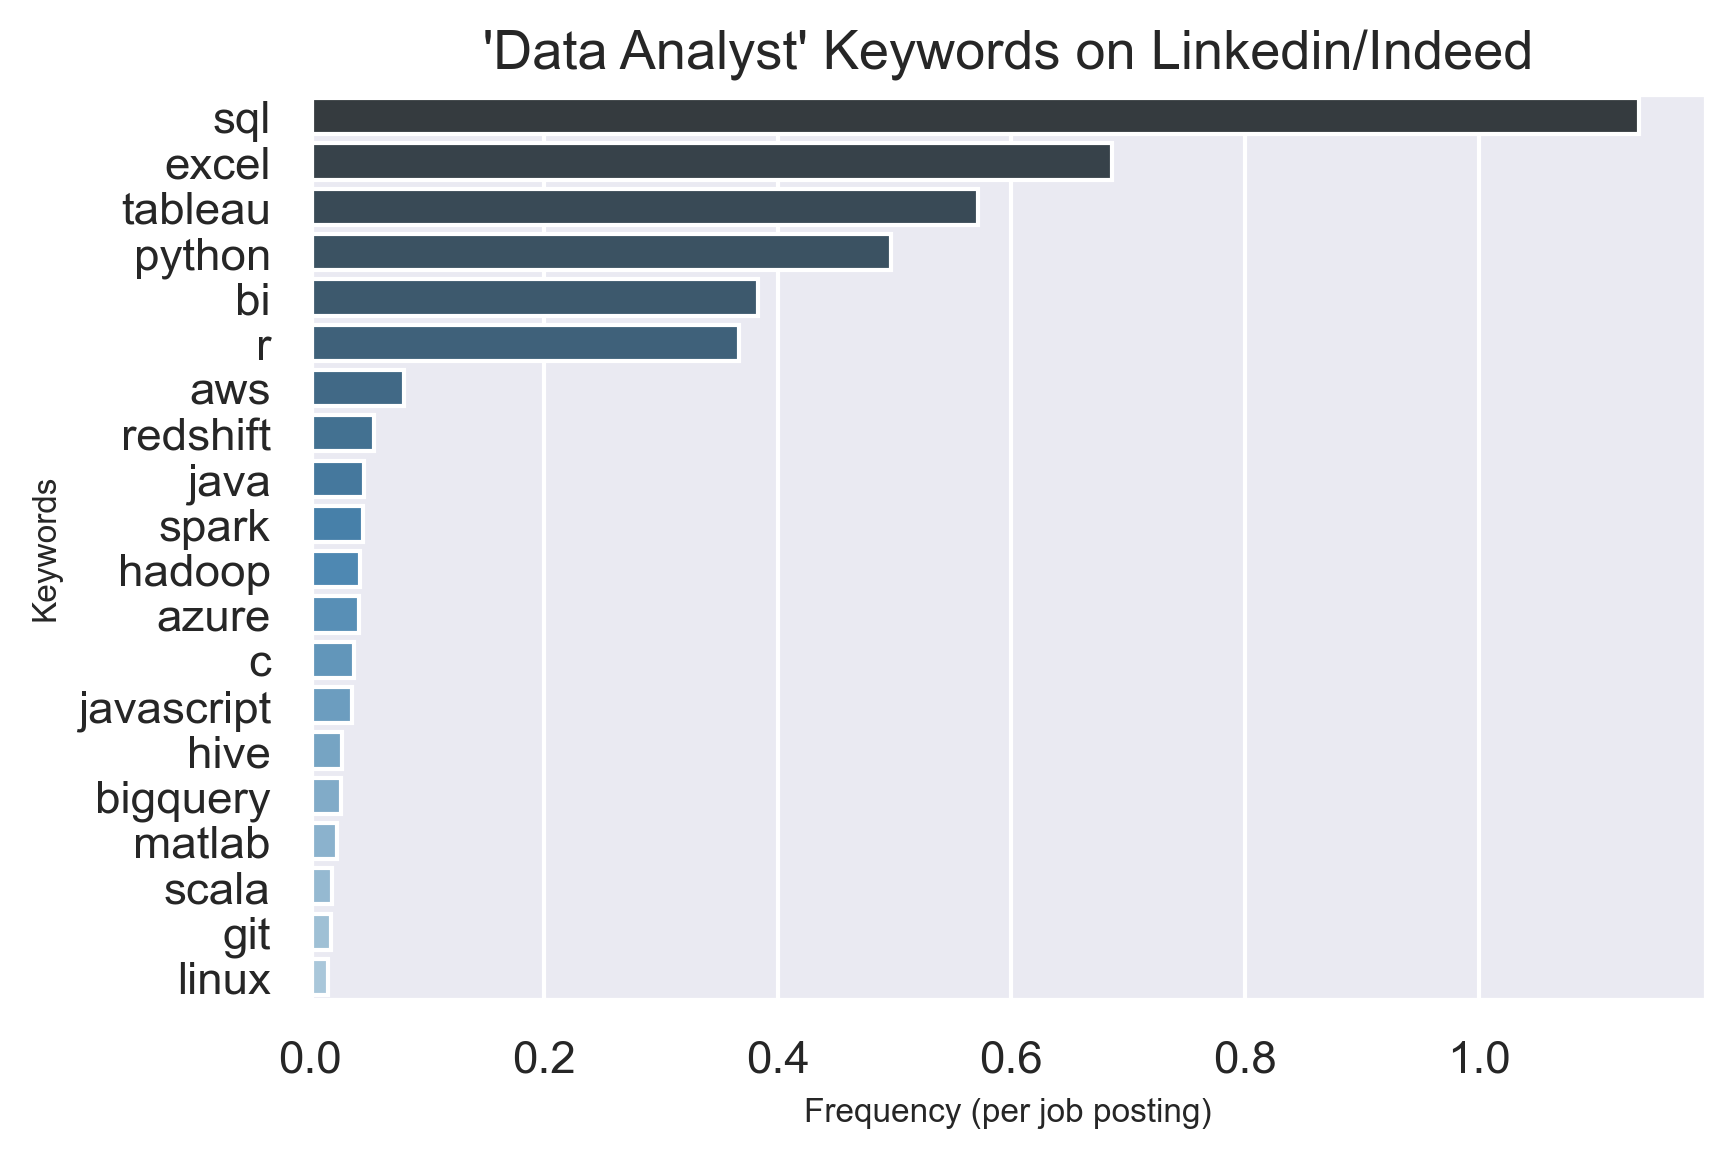

In [77]:
data_tools(df_jobs, 'Data Analyst')

<class 'list'>

Data Engineer Top Keywords:

     keywords  counts  avg_frequency_per_job
0        sql   23581               1.551586
1     python   17491               1.150875
2        aws   14321               0.942295
3      spark   11438               0.752599
4      azure    9853               0.648309
5       java    6980               0.459271
6     hadoop    6704               0.441111
7         bi    5089               0.334847
8   redshift    4803               0.316028
9      kafka    4765               0.313528
10     scala    4614               0.303593
11   tableau    3911               0.257336
12      hive    3823               0.251546
13   airflow    3656               0.240558
14         r    2932               0.192920
15       git    1999               0.131530
16    docker    1886               0.124095
17     linux    1712               0.112646
18         c    1645               0.108238
19   mongodb    1357               0.089288


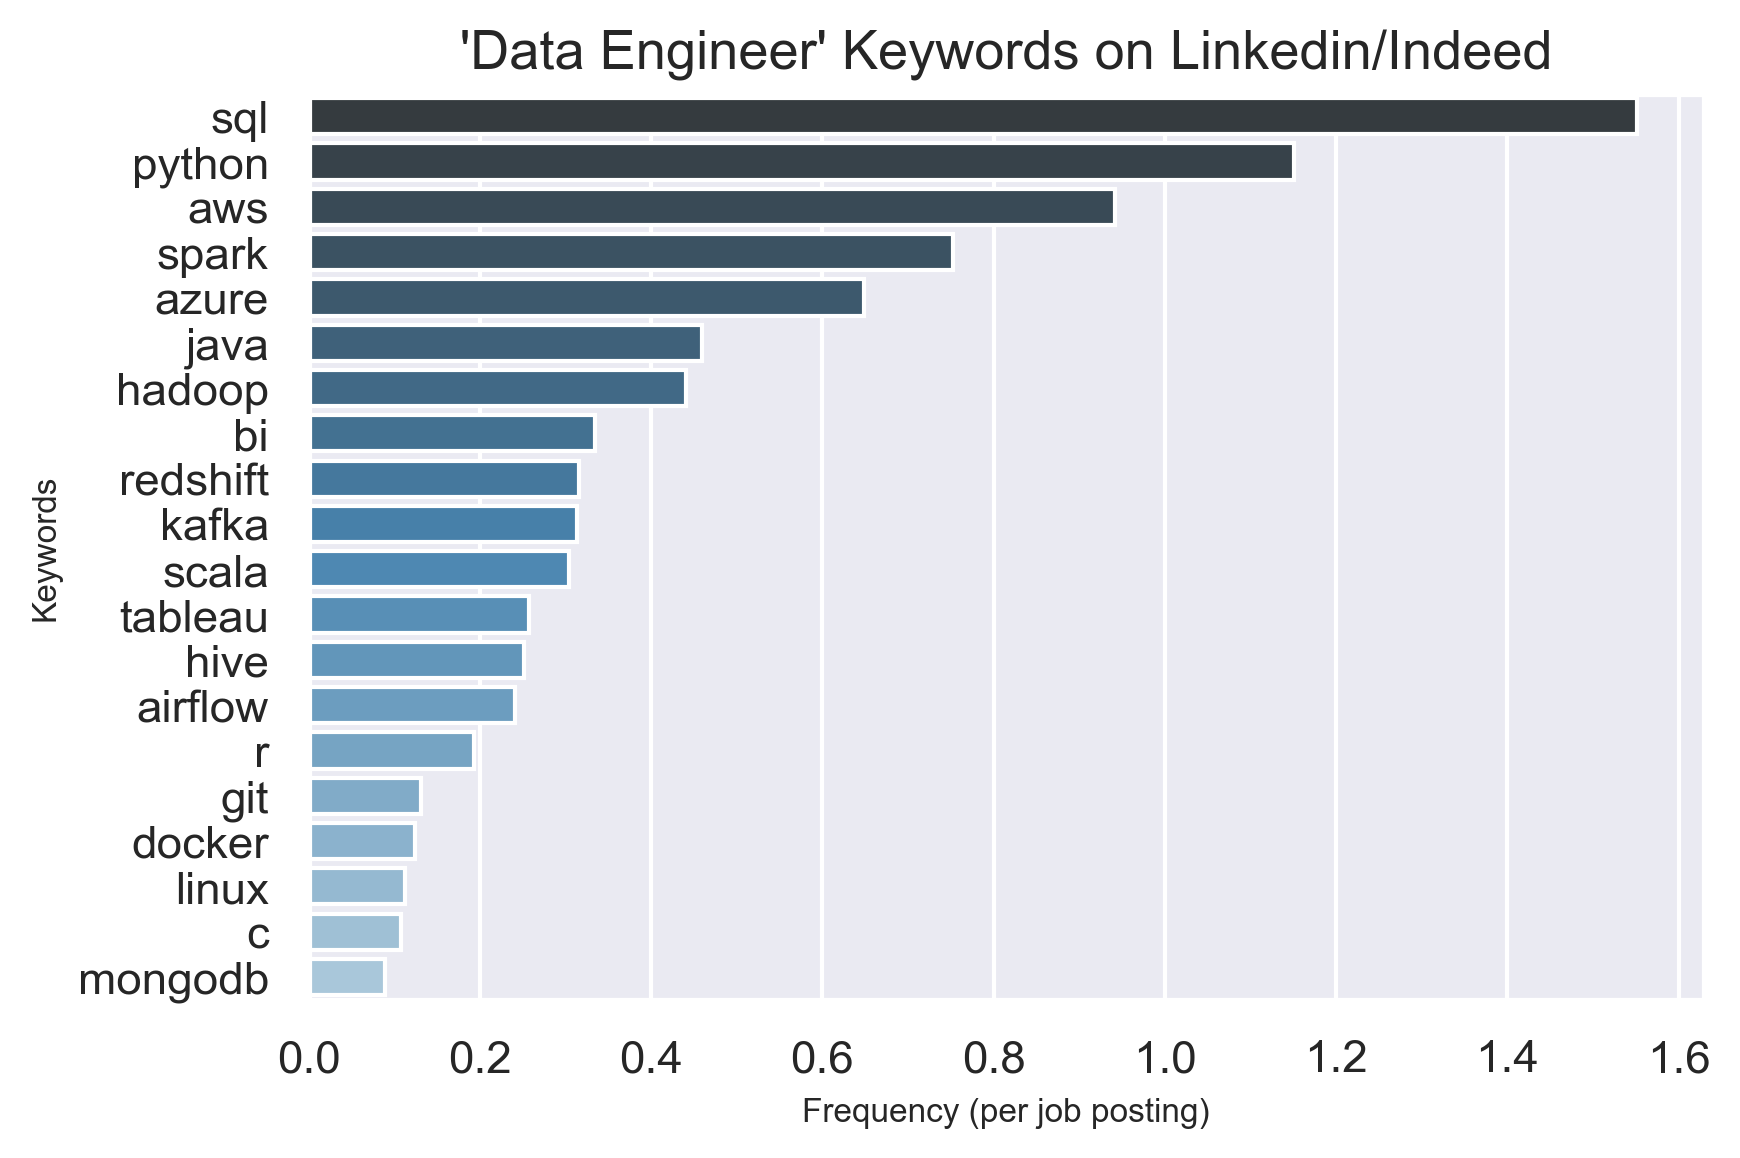

In [78]:
data_tools(df_jobs, 'Data Engineer')

<class 'list'>

Data Scientist Top Keywords:

       keywords  counts  avg_frequency_per_job
0       python   18520               1.268146
1            r   12715               0.870652
2          sql   12551               0.859422
3        spark    4626               0.316763
4      tableau    4452               0.304848
5          aws    4036               0.276363
6       hadoop    3356               0.229800
7         java    3255               0.222884
8   tensorflow    2566               0.175705
9        scala    2060               0.141057
10        hive    1804               0.123528
11       azure    1763               0.120720
12       excel    1761               0.120583
13      matlab    1735               0.118803
14          bi    1720               0.117776
15     pytorch    1569               0.107436
16           c    1245               0.085251
17         git    1059               0.072514
18       linux     865               0.059230
19      docker     760           

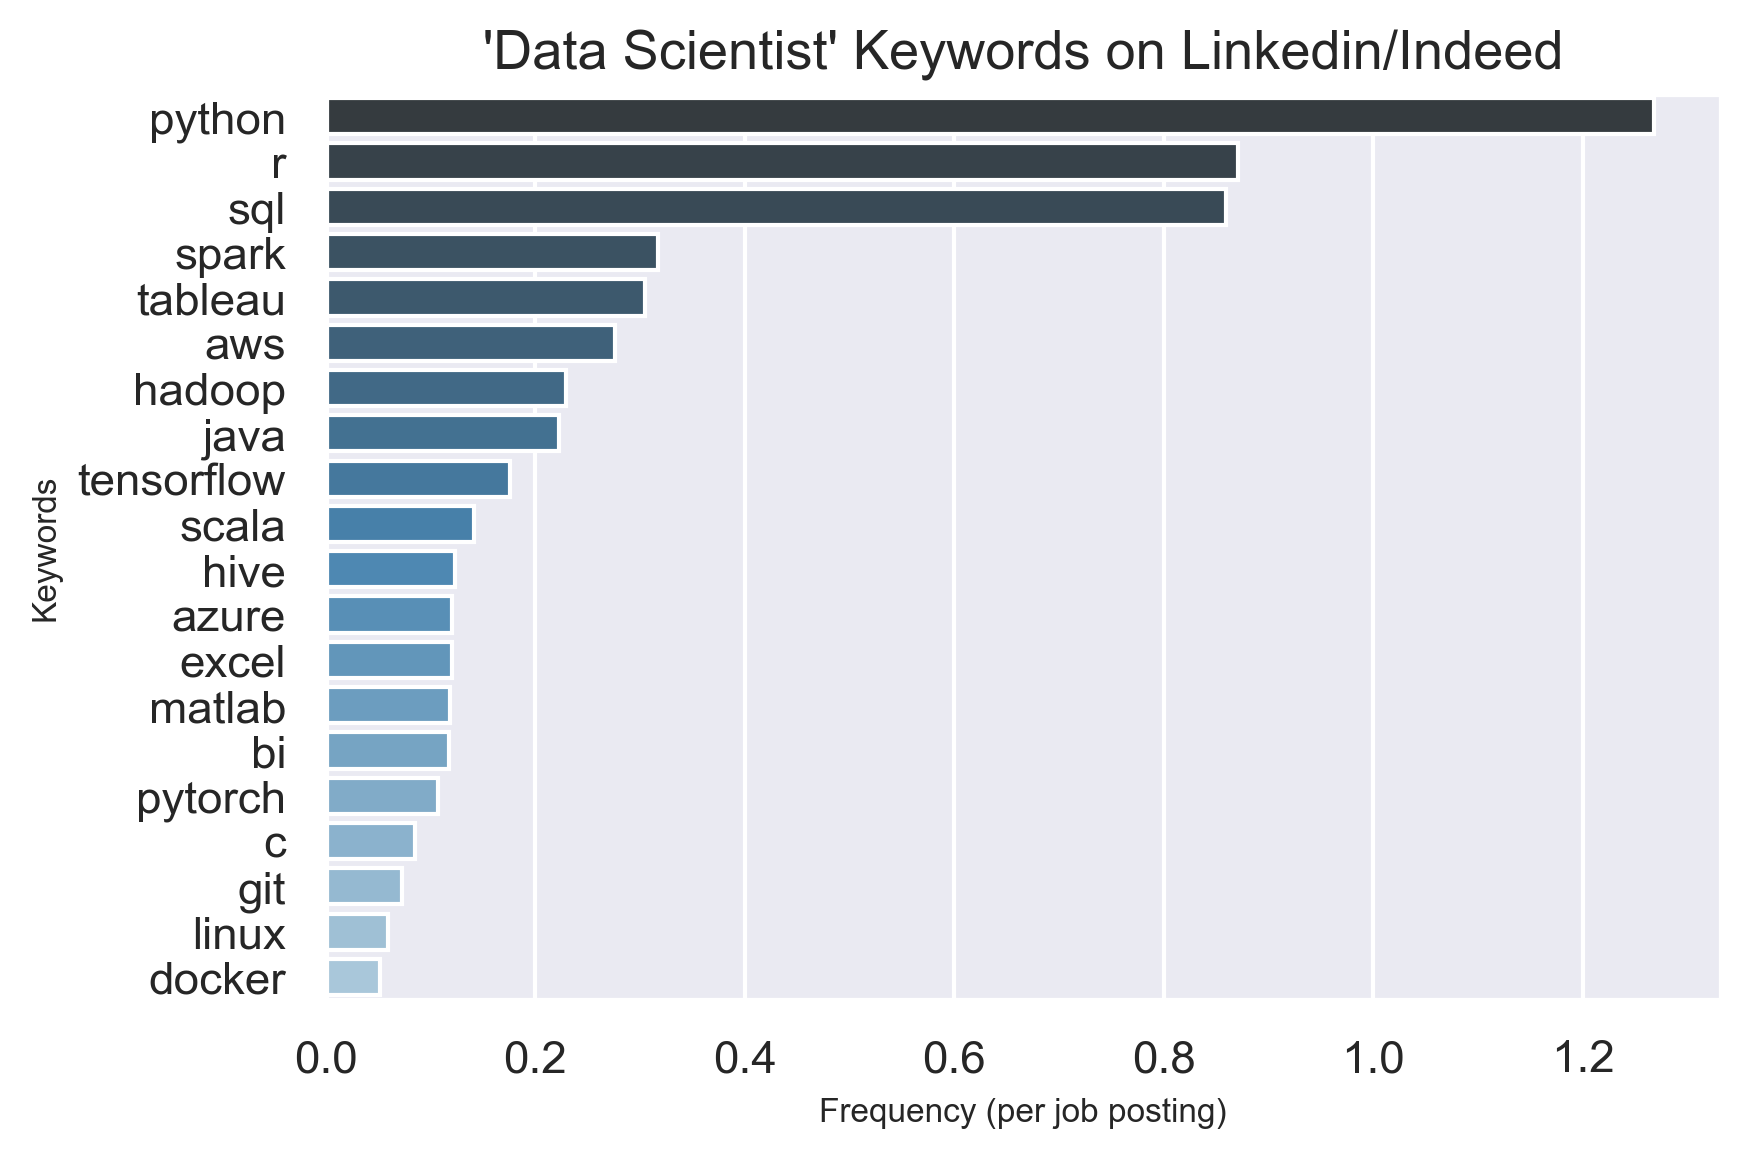

In [79]:
data_tools(df_jobs, 'Data Scientist')

### 3.2 Most Frequent Skills per Job 

In [80]:
# preprocess job description string 
def preprocess_text(df):
    
    df = df.copy()

    processed_text = []
    
    for x in df['clean_text']:

        # # Convert the tokens into lowercase: lower_tokens
        lower_tokens = [x.lower()]
        
        # # Convert tokens
        tokenize = [word_tokenize(x) for x in lower_tokens]
  
        # # # Retain alphabetic words: alpha_only
        alpha_only = [i for item in tokenize for i in item if i.isalpha()]

        # set stop words
        stop_words = set(stopwords.words('english')) 

        # # Remove all stop words: no_stops
        no_stops = [i for i in alpha_only if i not in stop_words]

        # # Instantiate the WordNetLemmatizer
        wordnet_lemmatizer = WordNetLemmatizer()

        # # Lemmatize all tokens into a new list: lemmatized
        lemmatized = [wordnet_lemmatizer.lemmatize(i) for i in no_stops]

        processed_text.append(lemmatized)
    
    df['processed_text'] = processed_text
    
    return df
            
df_jobs = preprocess_text(df_jobs)

df_jobs.head()

,company,company_rating,date,industries,job_text,job_title,location,clean_text,job_text_length,label,processed_text
0,Microf,NaN,2021-03-18 08:10:59,Marketing and Advertising,"['', 'Eligible for participation in the Compan...",Data Analyst,"Roswell, GA","['', 'Eligible for participation in the Compan...",6529,2,"[participation, company, group, medical, plan,..."
1,NaN,NaN,2021-03-18 08:10:59,NaN,"['', 'Qualifications', ""Understand the day-to-...",Data Analyst,New York City Metropolitan Area,"['', 'Qualifications', ""Understand the day-to-...",1169,2,"[understand, issue, business, face, better, un..."
2,Adobe,NaN,2021-03-18 08:10:59,Marketing and Advertising,"['', 'Define, measure and track key metrics to...",2021 Intern - Data Analyst,"California, United States","['', 'Define, measure and track key metrics to...",1940,2,"[measure, track, key, metric, guide, execution..."
3,"Prescryptive Health, Inc.",NaN,2021-03-18 08:10:59,Information Technology and Services,"['', '\tPrescryptive Health is putting an end ...",Data Analyst,"Redmond, WA","['', '\tPrescryptive Health is putting an end ...",3053,2,"[health, putting, end, nation, prescription, d..."
4,Source One Technical Solutions,NaN,2021-03-18 08:10:59,Information Technology and Services,"['', 'Qualifications', '• Analytical and data ...",Data Analyst,"Richboro, PA","['', 'Qualifications', '• Analytical and data ...",1100,2,"[analytical, data, visualization, skill, requi..."


In [81]:
def ngram_generator(df, n, title):
    
    # filter for job title
    df_jobs = df[(df['job_title'].str.contains(title, case=False))]
    
    # create empty list
    ngram_list = []

    # loop over every row in df_jobs['clean_text']
    for x in df_jobs['processed_text']:
        
        # join each list of strings into sentence
        joined = [' '.join(x)]        
        
        # create list of trigrams within each row
        ngram = [list(ngrams(item.split(), n)) for item in joined]

        # append list of trigrams to empty list
        ngram_list.append(ngram)
    
    # extract item within each sublist
    ngram_list = [item for sublist in ngram_list for item in sublist]
    
    # extract each item within sublist again for Counter (list is unhashable)
    ngram_list = [item for sublist in ngram_list for item in sublist]
    
    # print the 20 most common grams via Counter function
    
    return list(Counter(ngram_list).most_common(20))

### Data Analyst

In [82]:
ngram_generator(df_jobs, 2, 'Data Analyst')

[(('indeed', 'center'), 4958),
 (('data', 'analysis'), 4766),
 (('year', 'experience'), 4627),
 (('job', 'review'), 3781),
 (('review', 'salary'), 3781),
 (('communication', 'skill'), 3470),
 (('data', 'set'), 2654),
 (('data', 'visualization'), 2597),
 (('personal', 'information'), 2520),
 (('computer', 'science'), 2503),
 (('job', 'company'), 2481),
 (('company', 'certification'), 2480),
 (('salary', 'resume'), 2479),
 (('lab', 'advice'), 2479),
 (('advice', 'job'), 2479),
 (('certification', 'event'), 2479),
 (('event', 'indeed'), 2479),
 (('center', 'indeed'), 2479),
 (('indeed', 'sell'), 2479),
 (('sell', 'personal'), 2479)]

### Data Engineer

In [83]:
ngram_generator(df_jobs, 2, 'Data Engineer')

[(('year', 'experience'), 17273),
 (('data', 'pipeline'), 13777),
 (('big', 'data'), 10145),
 (('computer', 'science'), 9833),
 (('data', 'warehouse'), 8137),
 (('experience', 'working'), 6087),
 (('data', 'engineering'), 5705),
 (('best', 'practice'), 5316),
 (('indeed', 'center'), 5290),
 (('machine', 'learning'), 5190),
 (('data', 'modeling'), 5123),
 (('data', 'quality'), 5099),
 (('data', 'set'), 5083),
 (('degree', 'computer'), 5077),
 (('experience', 'data'), 4989),
 (('data', 'source'), 4939),
 (('communication', 'skill'), 4908),
 (('data', 'science'), 4892),
 (('data', 'model'), 4689),
 (('job', 'review'), 4160)]

### Data Scientist

In [84]:
ngram_generator(df_jobs, 2, 'Data Scientist')

[(('machine', 'learning'), 23459),
 (('data', 'science'), 20154),
 (('year', 'experience'), 11336),
 (('computer', 'science'), 10376),
 (('data', 'analysis'), 6340),
 (('data', 'set'), 5859),
 (('communication', 'skill'), 5749),
 (('indeed', 'center'), 5020),
 (('data', 'visualization'), 4594),
 (('experience', 'data'), 4501),
 (('job', 'review'), 4374),
 (('review', 'salary'), 4374),
 (('related', 'field'), 4358),
 (('big', 'data'), 4308),
 (('python', 'r'), 4240),
 (('deep', 'learning'), 4175),
 (('r', 'python'), 3815),
 (('data', 'mining'), 3754),
 (('data', 'source'), 3749),
 (('programming', 'language'), 3533)]

### 3.3 Most Frequent Companies Posting Jobs 

In [85]:
def job_companies(df, title):
    
    # replace various Amazon company names with Amazon
    df['company'] = df['company'].replace(to_replace = 'Amazon Web Services (AWS)', value = 'Amazon')
    df['company'] = df['company'].replace(to_replace = 'Amazon.com Services LLC', value = 'Amazon')
    df['company'] = df['company'].replace(to_replace = 'Amazon Web Services, Inc.', value = 'Amazon')

    # print value counts for companies to determine top 20 companies for each type of job posting
    title_companies = df[(df['job_title'].str.contains(title, case=False))]['company'].value_counts().iloc[:20]   
    print('\nMost Frequent Companies for {} Job Postings: \n\n{}'.format(title, title_companies))
 
    # plot most frequent companies
    sns.set()
    fig, ax = plt.subplots(figsize = (12,8), dpi=250)
    sns.barplot(x = title_companies.iloc[:10].index, y= title_companies.iloc[:10].values, palette="Blues_d")
    plt.title(label = "Most Frequent Companies for " + title + " Jobs", fontsize=14) 
    plt.xlabel('Companies', fontsize=14)
    plt.ylabel('No. of Postings', fontsize=14)
    plt.xticks(rotation=45, fontsize=12) 
    plt.show()


### Data Analyst


Most Frequent Companies for Data Analyst Job Postings: 

CyberCoders                      30
Facebook                         29
Forfeiture Support Associates    26
GEICO                            24
ClearedJobs.Net                  24
Amazon                           23
Booz Allen Hamilton              23
Kelly                            17
Apex Systems                     17
CACI                             17
Intuit                           17
Insight Global                   16
Tesla                            15
Robert Half                      14
Kforce Inc                       14
Piper Companies                  14
Guidehouse                       13
UnitedHealth Group               13
Vanguard                         13
Microsoft                        13
Name: company, dtype: int64


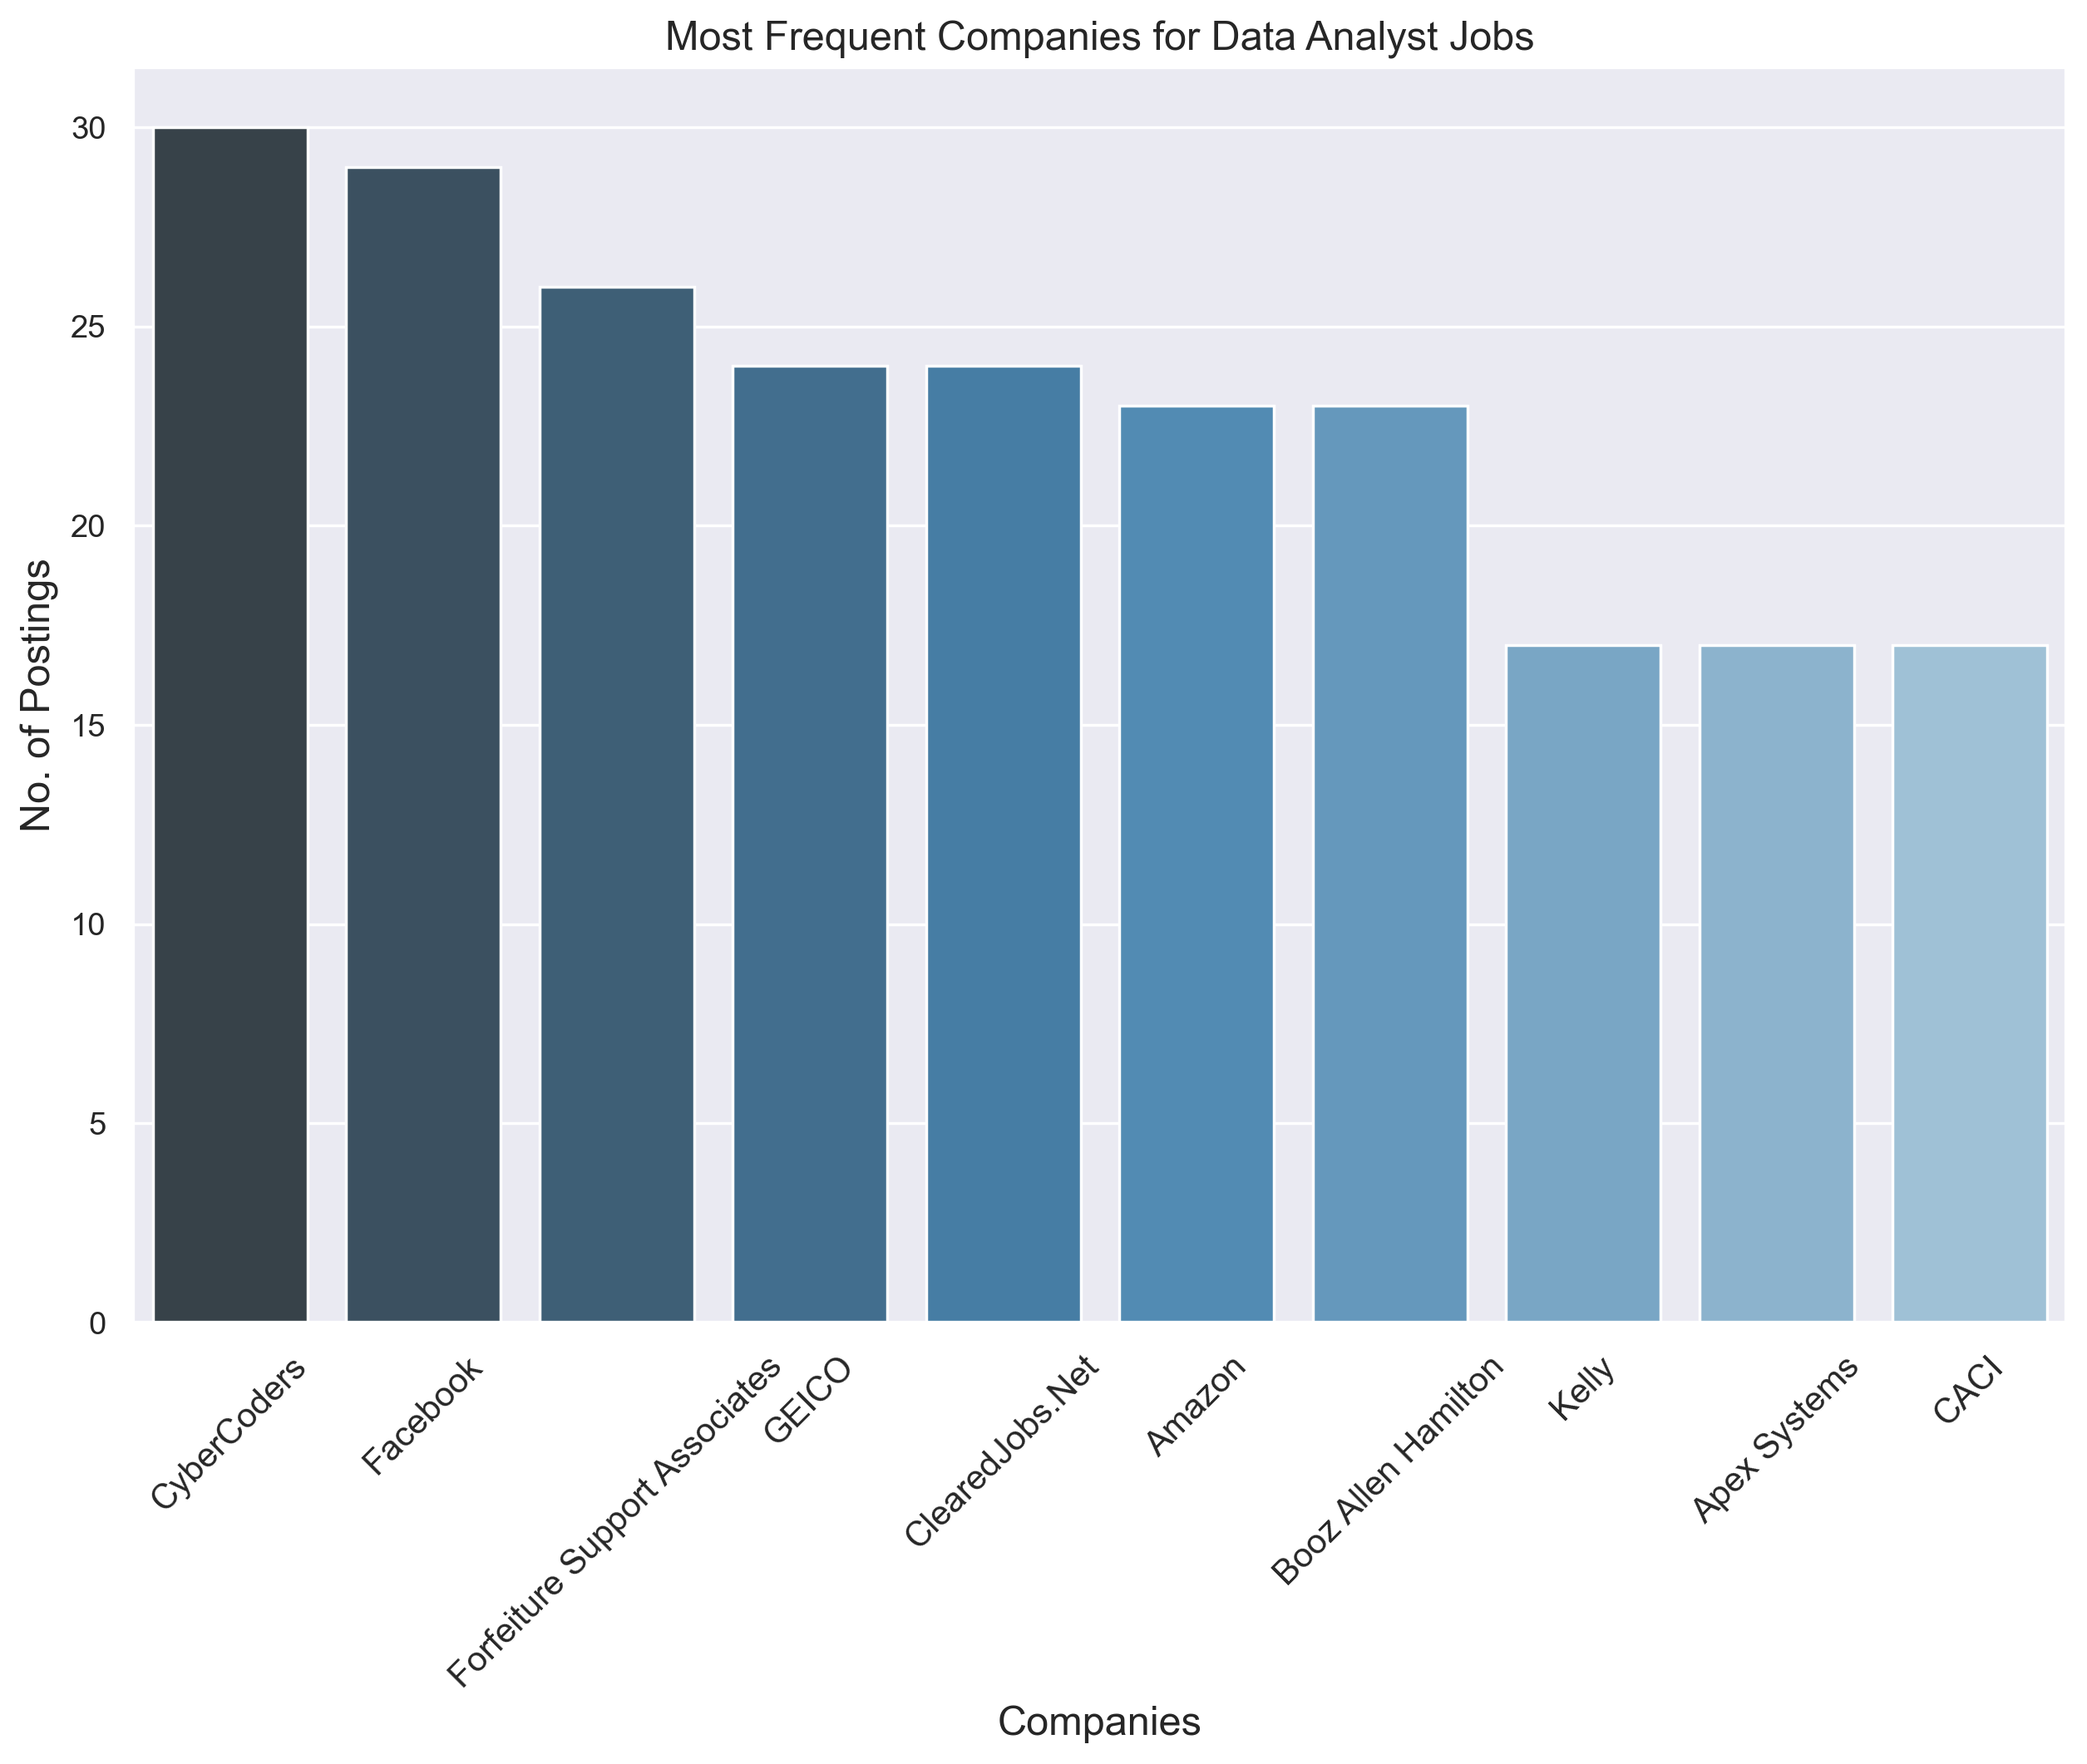

In [86]:
job_companies(df_jobs, 'Data Analyst')

### Data Engineer


Most Frequent Companies for Data Engineer Job Postings: 

Amazon                  332
Facebook                149
Optello                 137
Apple                   115
CyberCoders             100
Booz Allen Hamilton      73
Jobot                    57
CVS Health               55
Harnham                  55
Accenture                53
Cognizant                51
Deloitte                 47
USAA                     47
Quantitative Systems     46
Tesla                    45
UnitedHealth Group       45
Apex Systems             44
Idexcel                  44
Brooksource              39
Capgemini                38
Name: company, dtype: int64


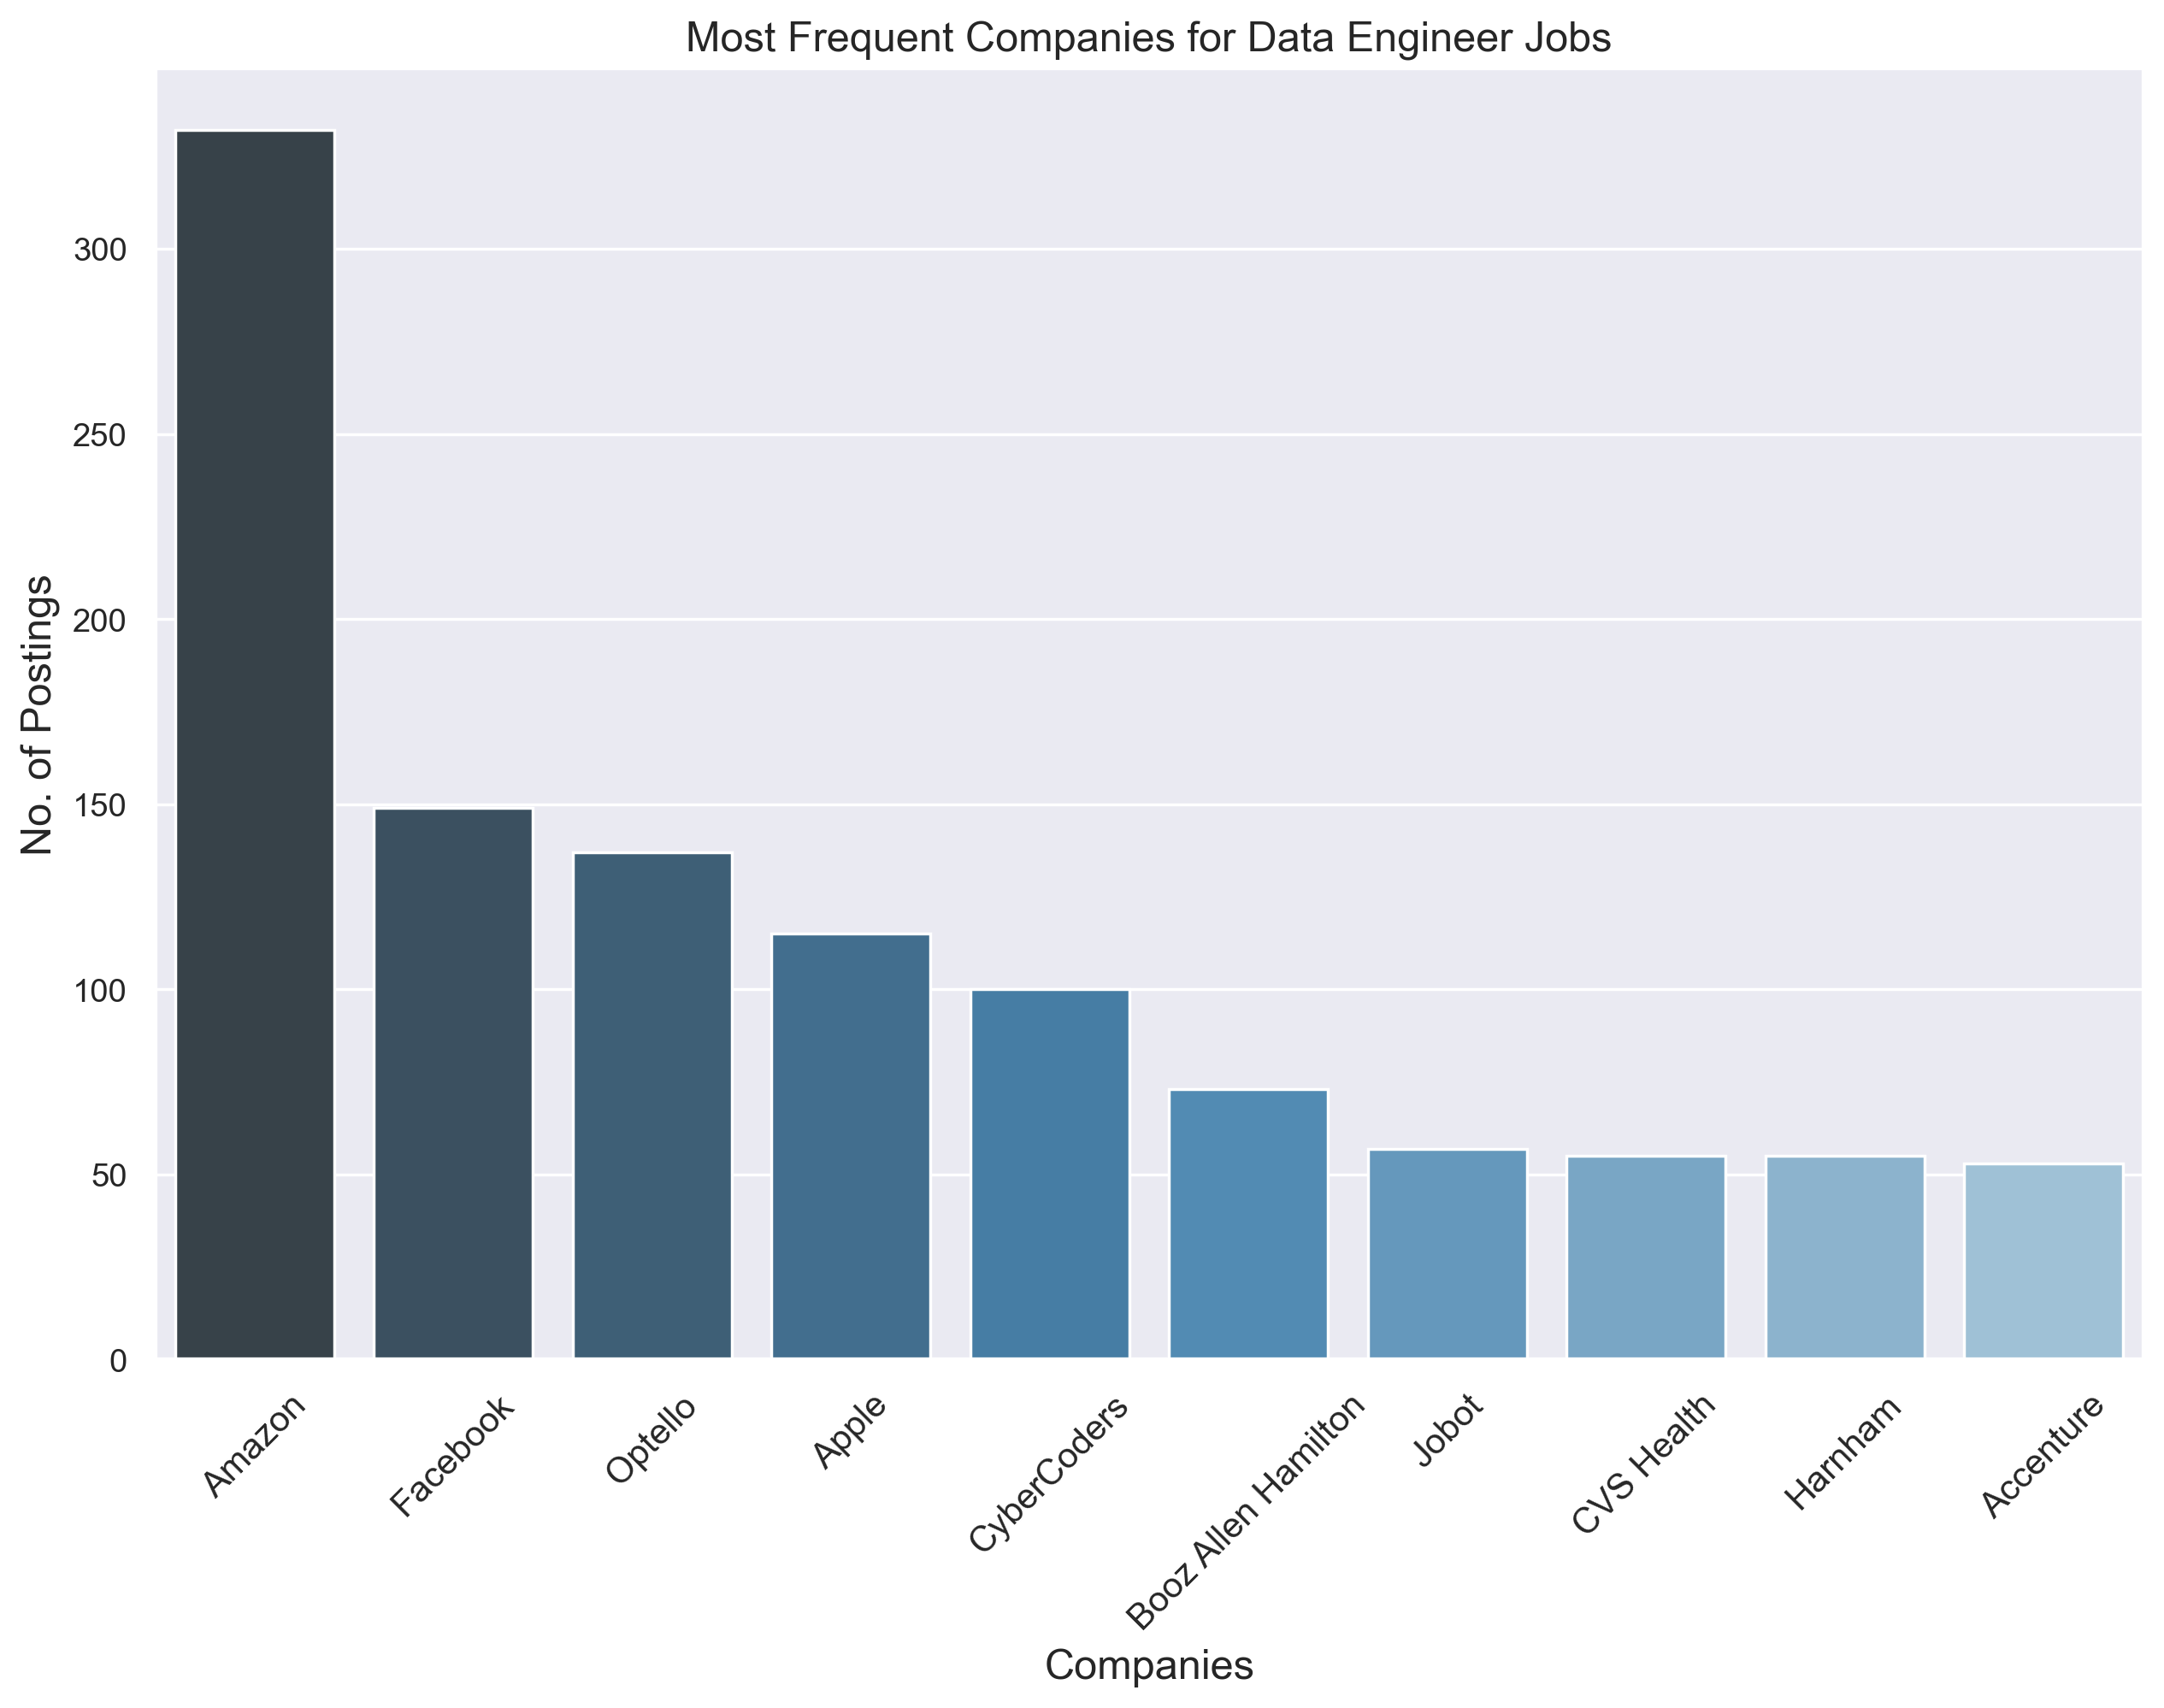

In [87]:
job_companies(df_jobs, 'Data Engineer')

### Data Scientist


Most Frequent Companies for Data Scientist Job Postings: 

Amazon                       271
Facebook                     206
Booz Allen Hamilton          158
Apple                        144
Optello                       98
CyberCoders                   78
ClearedJobs.Net               76
CVS Health                    69
Bayer                         68
Microsoft                     65
IBM                           65
Leidos                        60
Deloitte                      57
JPMorgan Chase Bank, N.A.     53
Harnham                       53
Guidehouse                    52
Walmart                       51
Spotify                       50
Mitre Corporation             49
PayPal                        48
Name: company, dtype: int64


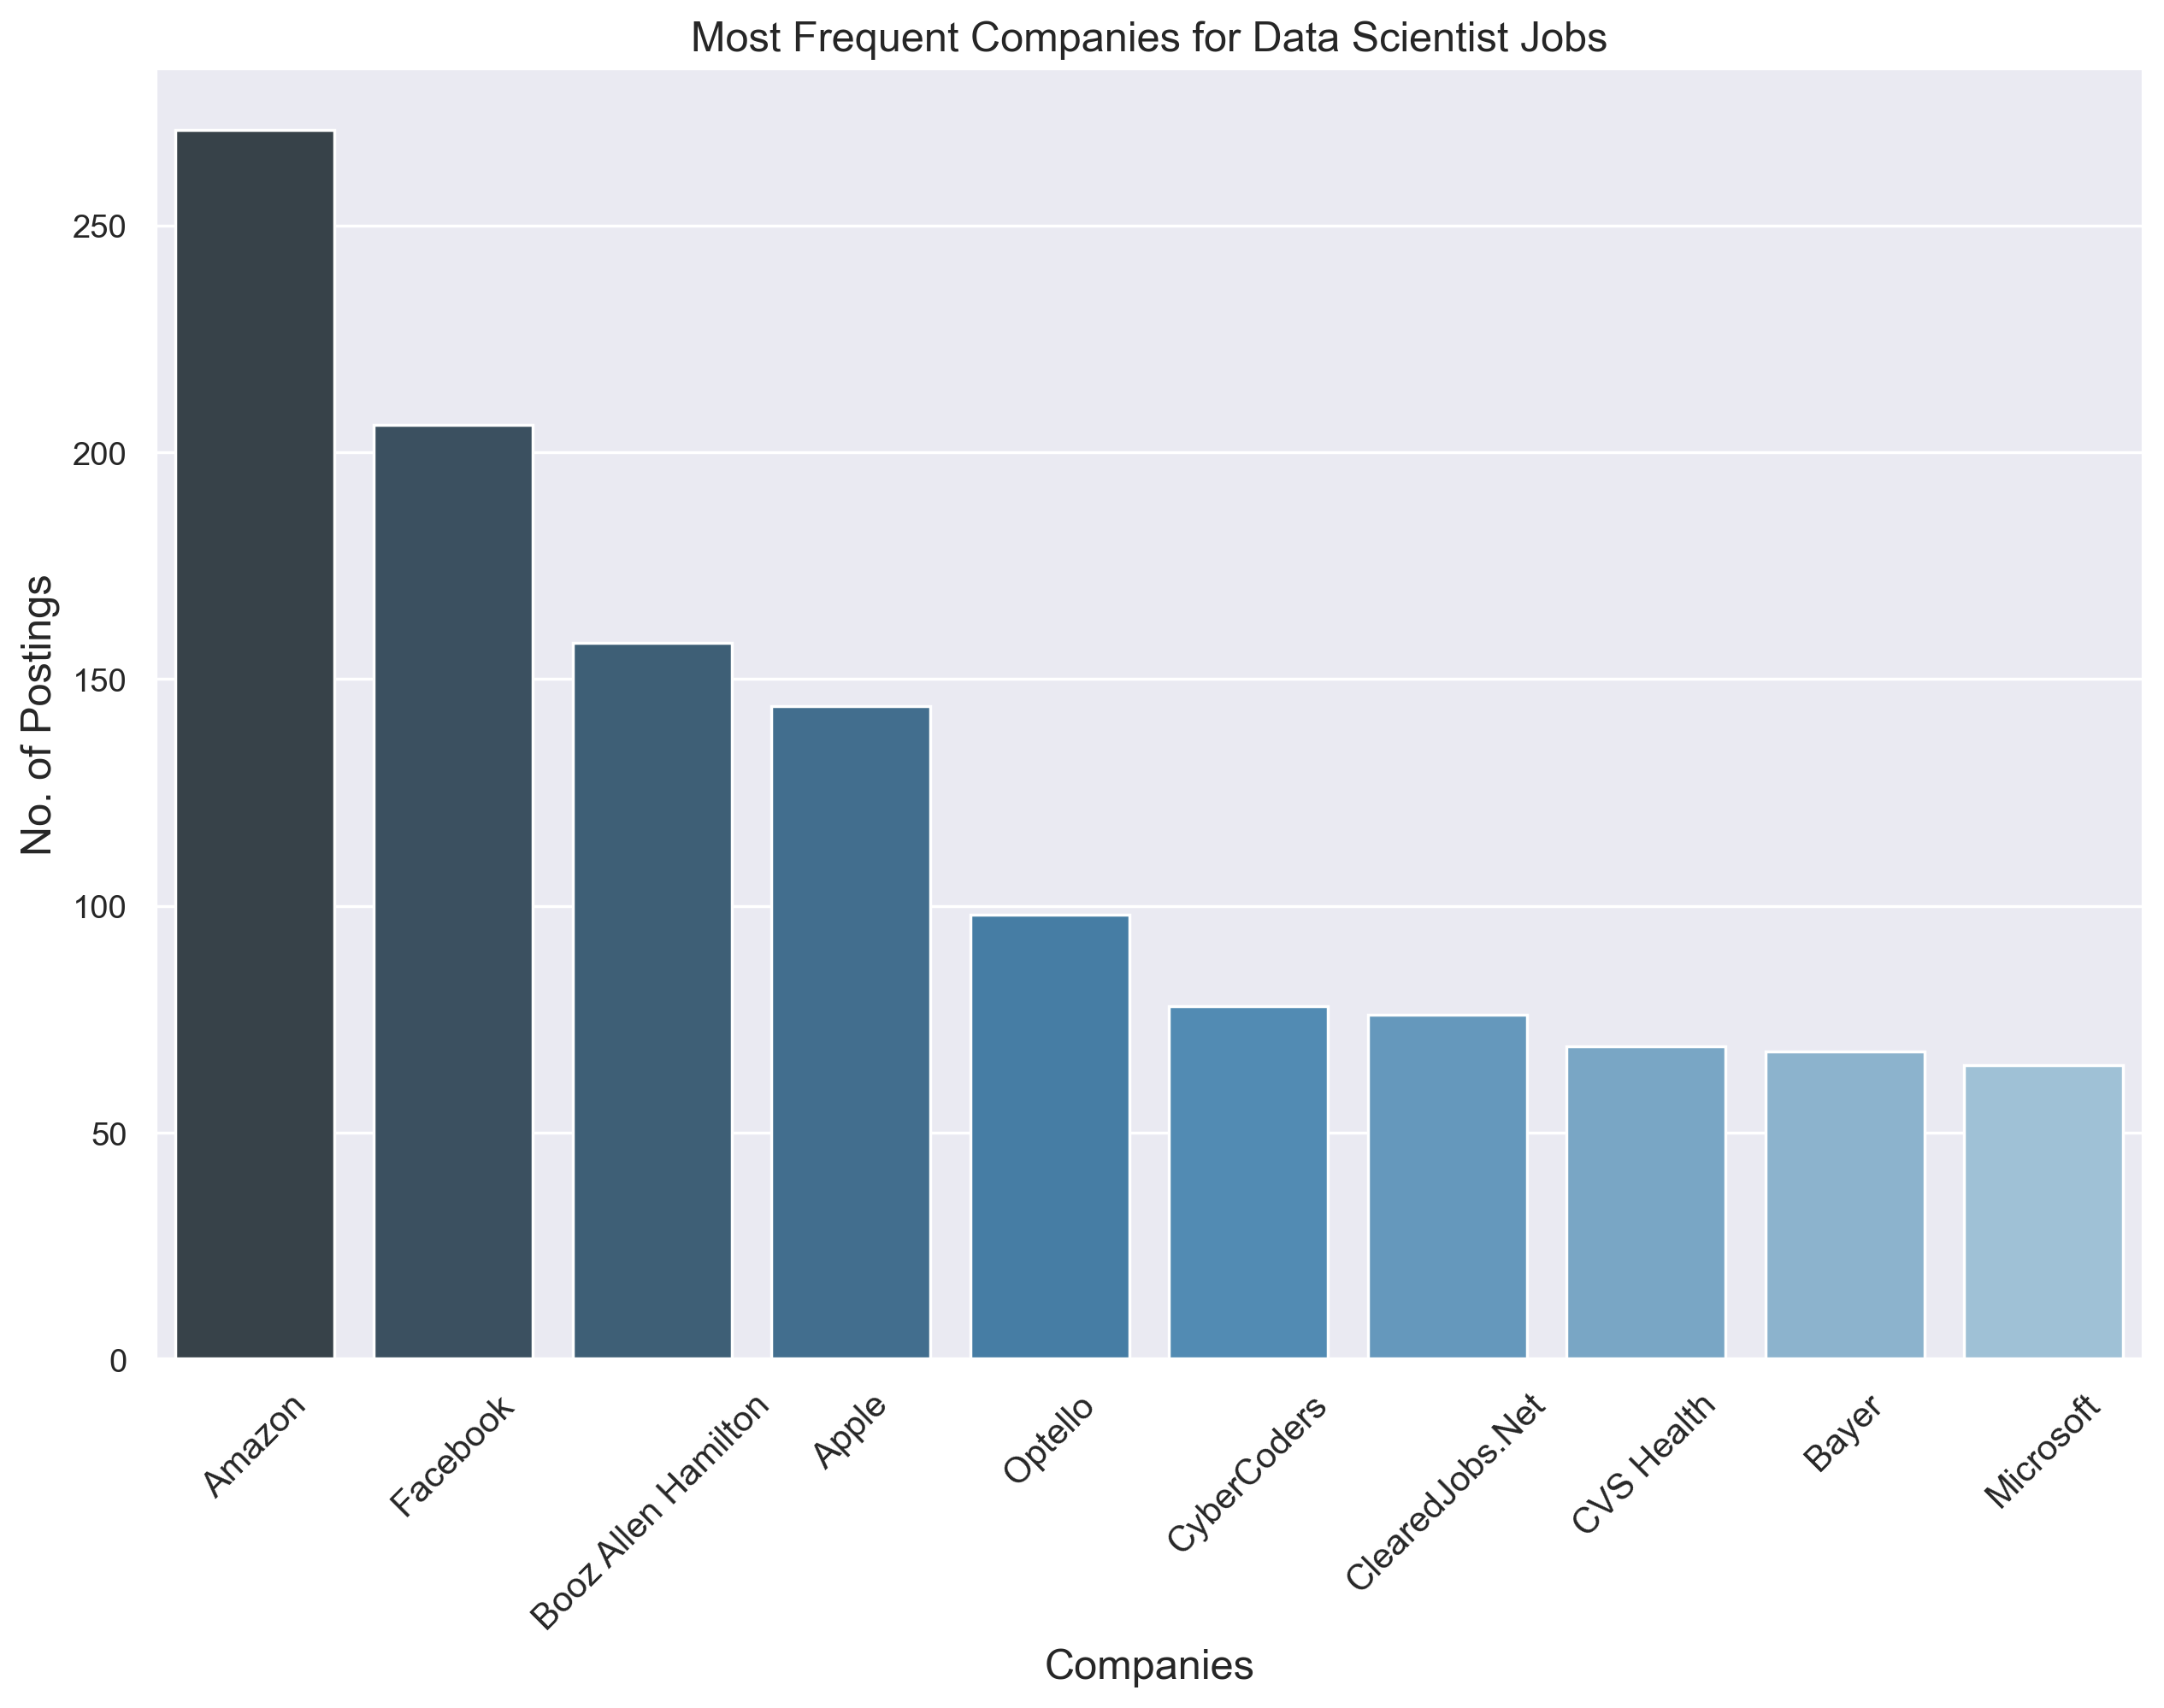

In [88]:
job_companies(df_jobs, 'Data Scientist')

## 4. Data Prediction

In [89]:
# # make series of job text for just Data Engineer and Data Scientist roles
def remove_obvious_words(df):
    
    updated_words = []

    for x in df['processed_text']:
        
        x = str(x)
        x = x.replace('scientist', '')
        x = x.replace('engineer', '')
        x = x.replace('analyst', '')
       
        # append updated strings to list
        updated_words.append(x)

    df['processed_text'] = updated_words
    
    return df
            
df_jobs = remove_obvious_words(df_jobs)
df_jobs.head()

,company,company_rating,date,industries,job_text,job_title,location,clean_text,job_text_length,label,processed_text
0,Microf,NaN,2021-03-18 08:10:59,Marketing and Advertising,"['', 'Eligible for participation in the Compan...",Data Analyst,"Roswell, GA","['', 'Eligible for participation in the Compan...",6529,2,"['participation', 'company', 'group', 'medical..."
1,NaN,NaN,2021-03-18 08:10:59,NaN,"['', 'Qualifications', ""Understand the day-to-...",Data Analyst,New York City Metropolitan Area,"['', 'Qualifications', ""Understand the day-to-...",1169,2,"['understand', 'issue', 'business', 'face', 'b..."
2,Adobe,NaN,2021-03-18 08:10:59,Marketing and Advertising,"['', 'Define, measure and track key metrics to...",2021 Intern - Data Analyst,"California, United States","['', 'Define, measure and track key metrics to...",1940,2,"['measure', 'track', 'key', 'metric', 'guide',..."
3,"Prescryptive Health, Inc.",NaN,2021-03-18 08:10:59,Information Technology and Services,"['', '\tPrescryptive Health is putting an end ...",Data Analyst,"Redmond, WA","['', '\tPrescryptive Health is putting an end ...",3053,2,"['health', 'putting', 'end', 'nation', 'prescr..."
4,Source One Technical Solutions,NaN,2021-03-18 08:10:59,Information Technology and Services,"['', 'Qualifications', '• Analytical and data ...",Data Analyst,"Richboro, PA","['', 'Qualifications', '• Analytical and data ...",1100,2,"['analytical', 'data', 'visualization', 'skill..."


In [90]:
# create feature and target series from dataframe
df_feature = df_jobs[(df_jobs['label'] == 0) | (df_jobs['label'] == 1) | (df_jobs['label'] == 2)].loc[:, 'processed_text']
df_target = df_jobs[(df_jobs['label'] == 0) | (df_jobs['label'] == 1) | (df_jobs['label'] == 2)].loc[:, 'label']                

In [91]:
# apply TF-IDF based feature representation
tfidf_vectorizer = TfidfVectorizer()
df_feature_TFIDF = tfidf_vectorizer.fit_transform(df_feature)

# split train/test data 80/20
X_train, X_test, y_train, y_test = train_test_split(df_feature_TFIDF, 
                                                    df_target, 
                                                    train_size=0.8, 
                                                    random_state=20)

In [92]:
# create empty dataframe to store model results and scores
model_results = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1'])
model_results

,model,accuracy,precision,recall,f1


### 4.1 Logistic Regression (One vs. All) w/ TFIDF (Model 1)

In [93]:
# define logistic regression, fit to model 
logreg_OVR_TFIDF = LogisticRegression(multi_class = 'ovr')
#log_reg_CV = LogisticRegression(solver='liblinear', penalty='l1')
logreg_OVR_TFIDF.fit(X_train, y_train)

LogisticRegression(multi_class='ovr')

In [94]:
# compute y-prediction and accuracy, recall, precision, and f1 scores
y_pred = logreg_OVR_TFIDF.predict(X_test)
mod1_acc = accuracy_score(y_test, y_pred)
mod1_recall = recall_score(y_test, y_pred, average='macro')
mod1_precision = precision_score(y_test, y_pred, average='macro')
mod1_f1 = f1_score(y_test, y_pred, average='macro')

# print accuracy, recall, precision, f1 score, detailed report
print('---------------------------------------')
print('Model 1 accuracy: ', round(mod1_acc,3))
print('Model 1 recall: ', round(mod1_recall,3))
print('Model 1 precision: ', round(mod1_precision,3))
print('Model 1 f1 : ', round(mod1_f1,3))
print('Model 1 classification report: \n',classification_report(y_test, y_pred))


---------------------------------------
Model 1 accuracy:  0.872
Model 1 recall:  0.853
Model 1 precision:  0.863
Model 1 f1 :  0.857
Model 1 classification report: 
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      2900
           1       0.90      0.91      0.90      3025
           2       0.82      0.76      0.79      1528

    accuracy                           0.87      7453
   macro avg       0.86      0.85      0.86      7453
weighted avg       0.87      0.87      0.87      7453



In [95]:
# append model results to dataframe
    # append to dataframe
model_results = model_results.append({'model': 'LogReg_OVR_TFIDF',
                      'accuracy':round(mod1_acc,3),
                      'recall': round(mod1_recall,3),
                      'precision': round(mod1_precision,3),
                      'f1': round(mod1_f1,3)}, ignore_index=True)

model_results

,model,accuracy,precision,recall,f1
0,LogReg_OVR_TFIDF,0.872,0.863,0.853,0.857


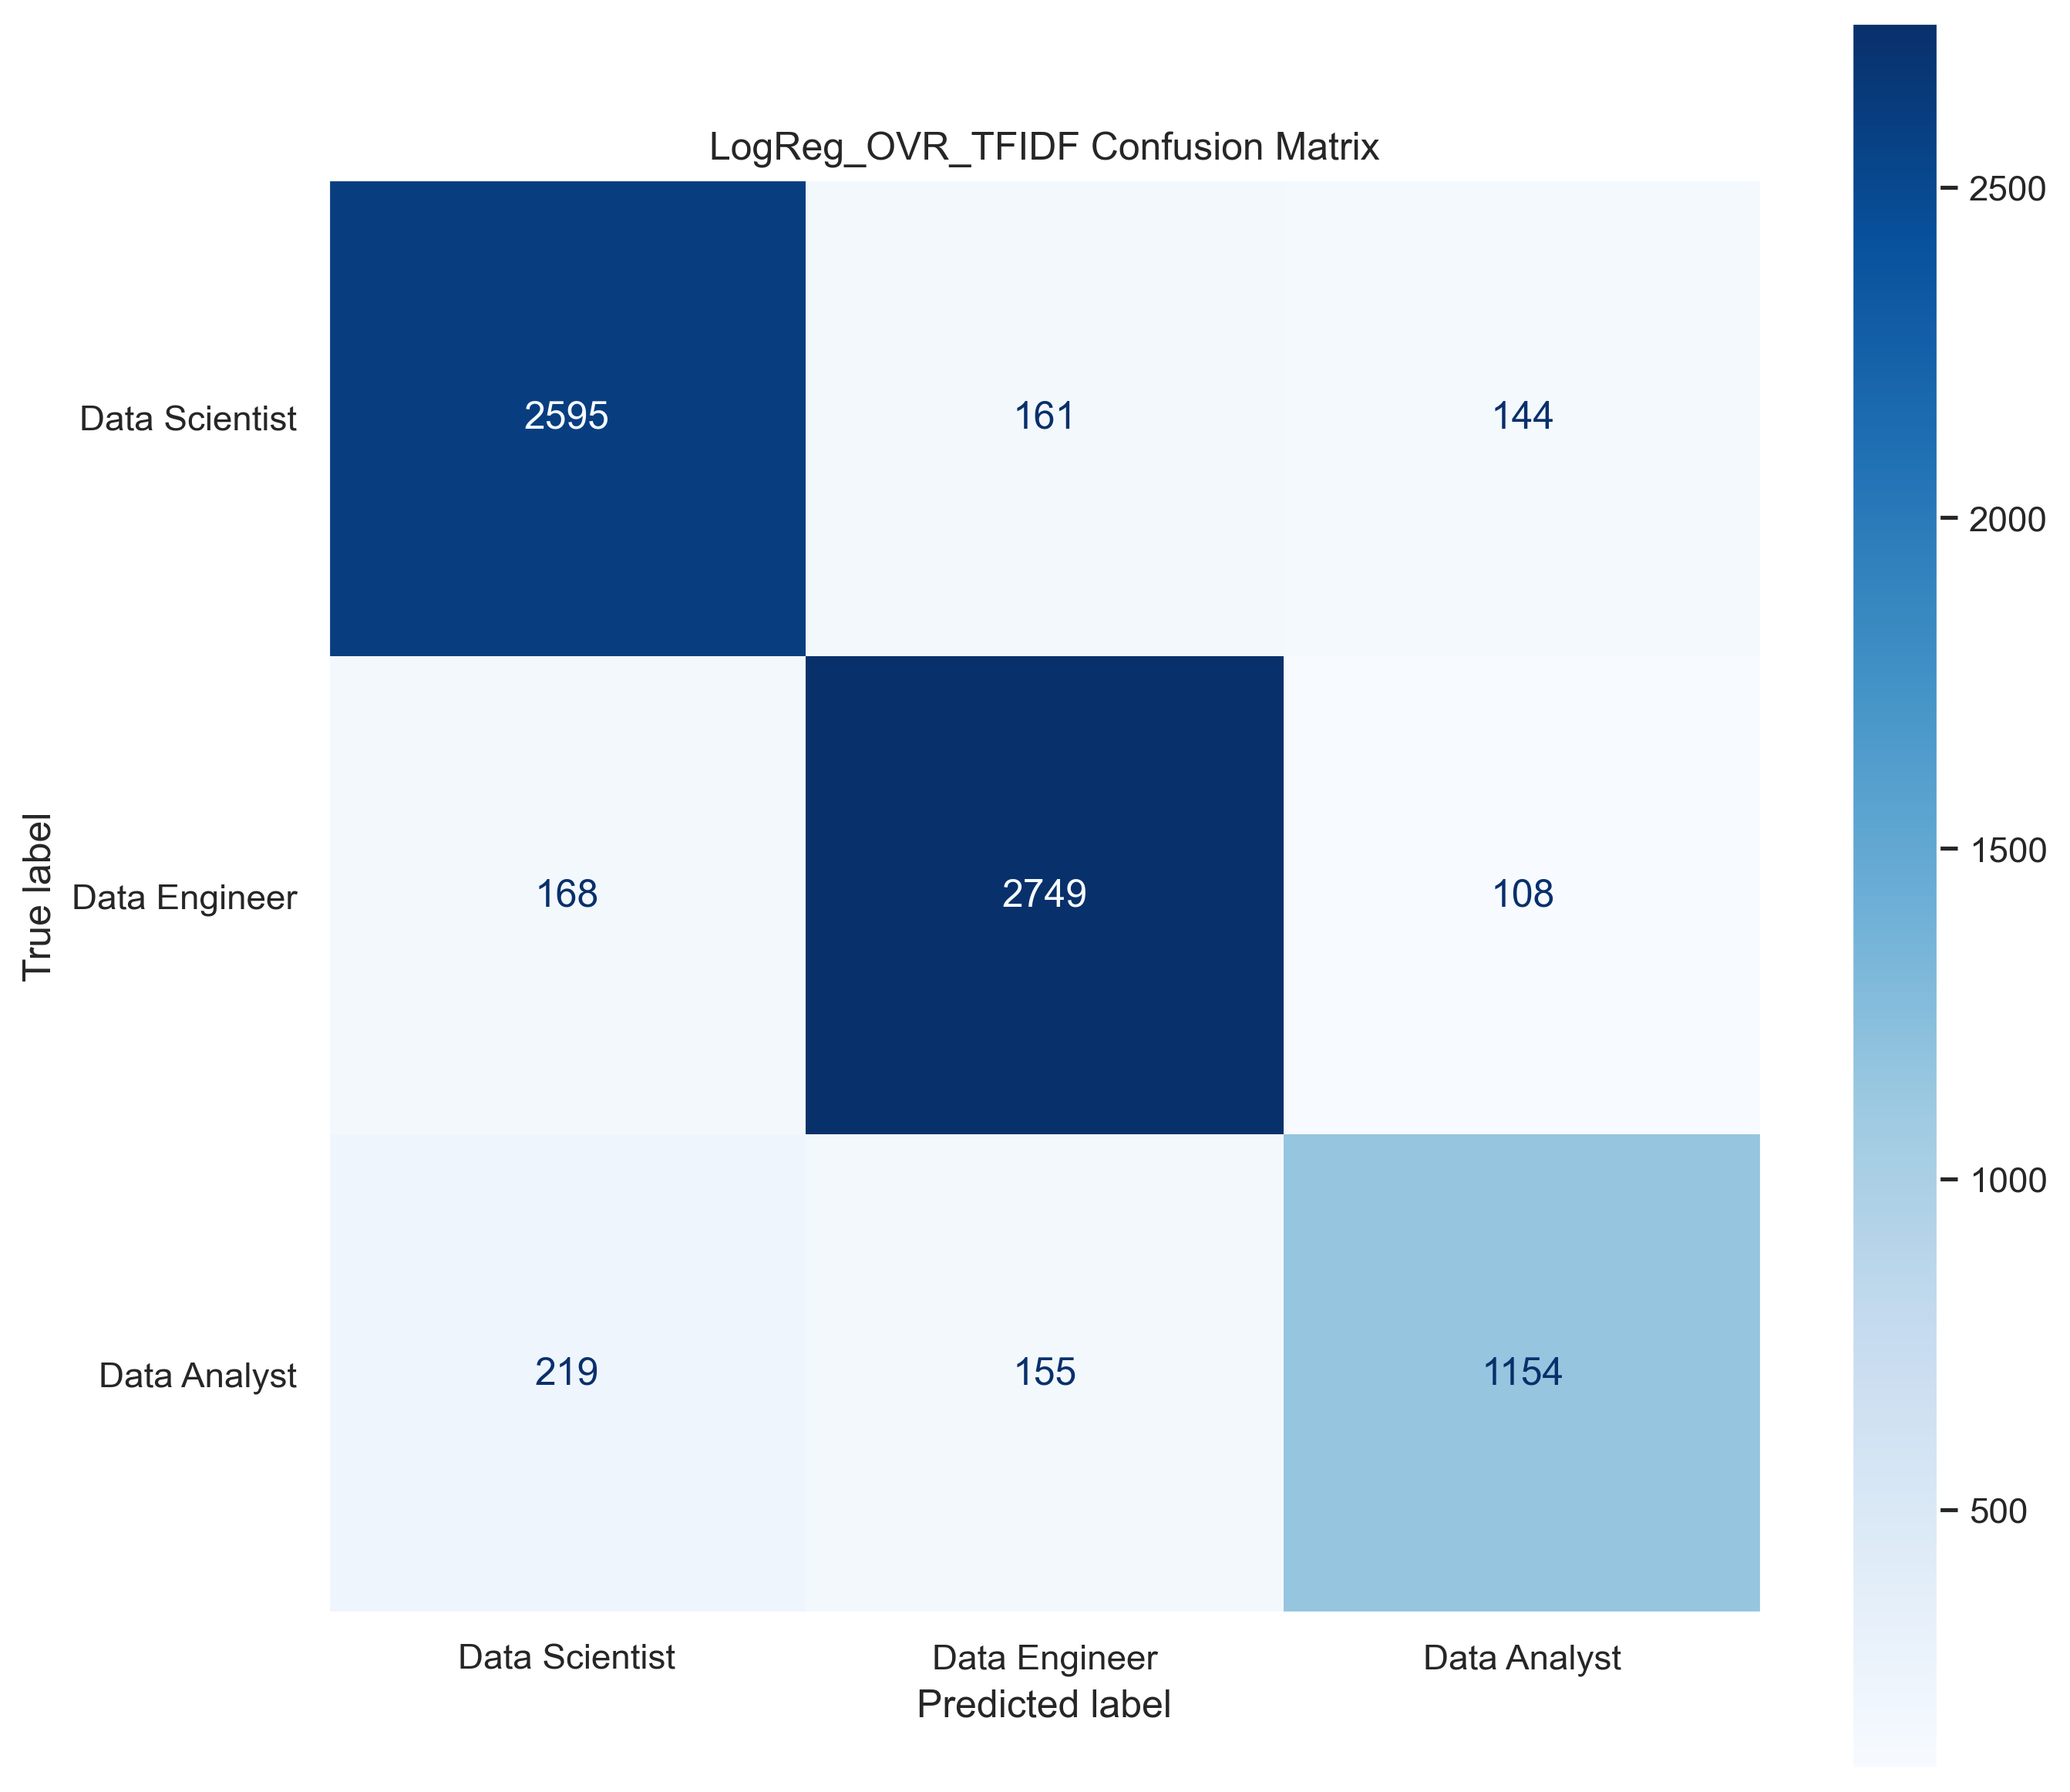

In [96]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

plot_confusion_matrix(logreg_OVR_TFIDF, X_test, y_test,
                             display_labels=['Data Scientist', 'Data Engineer', 'Data Analyst'],
                             cmap=plt.cm.Blues, ax=ax)
ax.set_title('LogReg_OVR_TFIDF Confusion Matrix')

plt.grid(None)
plt.show()

### 4.2 Logistic Regression (Multinomial) w/ TF-IDF (Model 2)

In [97]:
# define logistic regression, fit to model                                                    
logreg_multi_TFIDF = LogisticRegression(multi_class = 'multinomial')
logreg_multi_TFIDF.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [98]:
# compute y-prediction and accuracy, recall, precision, and f1 scores
y_pred = logreg_multi_TFIDF.predict(X_test)
mod2_acc = accuracy_score(y_test, y_pred)
mod2_recall = recall_score(y_test, y_pred, average = 'macro')
mod2_precision = precision_score(y_test, y_pred, average = 'macro')
mod2_f1 = f1_score(y_test, y_pred, average = 'macro')

# print accuracy, recall, precision, f1 score, detailed report
print('---------------------------------------')
print('Model 2 accuracy: ', round(mod2_acc,3))
print('Model 2 recall: ', round(mod2_recall,3))
print('Model 2 precision: ', round(mod2_precision,3))
print('Model 2 f1 : ', round(mod2_f1,3))
print('Model 2 classification report: \n',classification_report(y_test, y_pred))


---------------------------------------
Model 2 accuracy:  0.88
Model 2 recall:  0.865
Model 2 precision:  0.87
Model 2 f1 :  0.867
Model 2 classification report: 
               precision    recall  f1-score   support

           0       0.88      0.90      0.89      2900
           1       0.91      0.91      0.91      3025
           2       0.82      0.78      0.80      1528

    accuracy                           0.88      7453
   macro avg       0.87      0.86      0.87      7453
weighted avg       0.88      0.88      0.88      7453



In [99]:
# append model results to dataframe
model_results = model_results.append({'model': 'LogReg_Multi_TFIDF',
                      'accuracy':round(mod2_acc,3),
                      'recall': round(mod2_recall,3),
                      'precision': round(mod2_precision,3),
                      'f1': round(mod2_f1,3)}, ignore_index=True)

model_results

,model,accuracy,precision,recall,f1
0,LogReg_OVR_TFIDF,0.872,0.863,0.853,0.857
1,LogReg_Multi_TFIDF,0.880,0.870,0.865,0.867


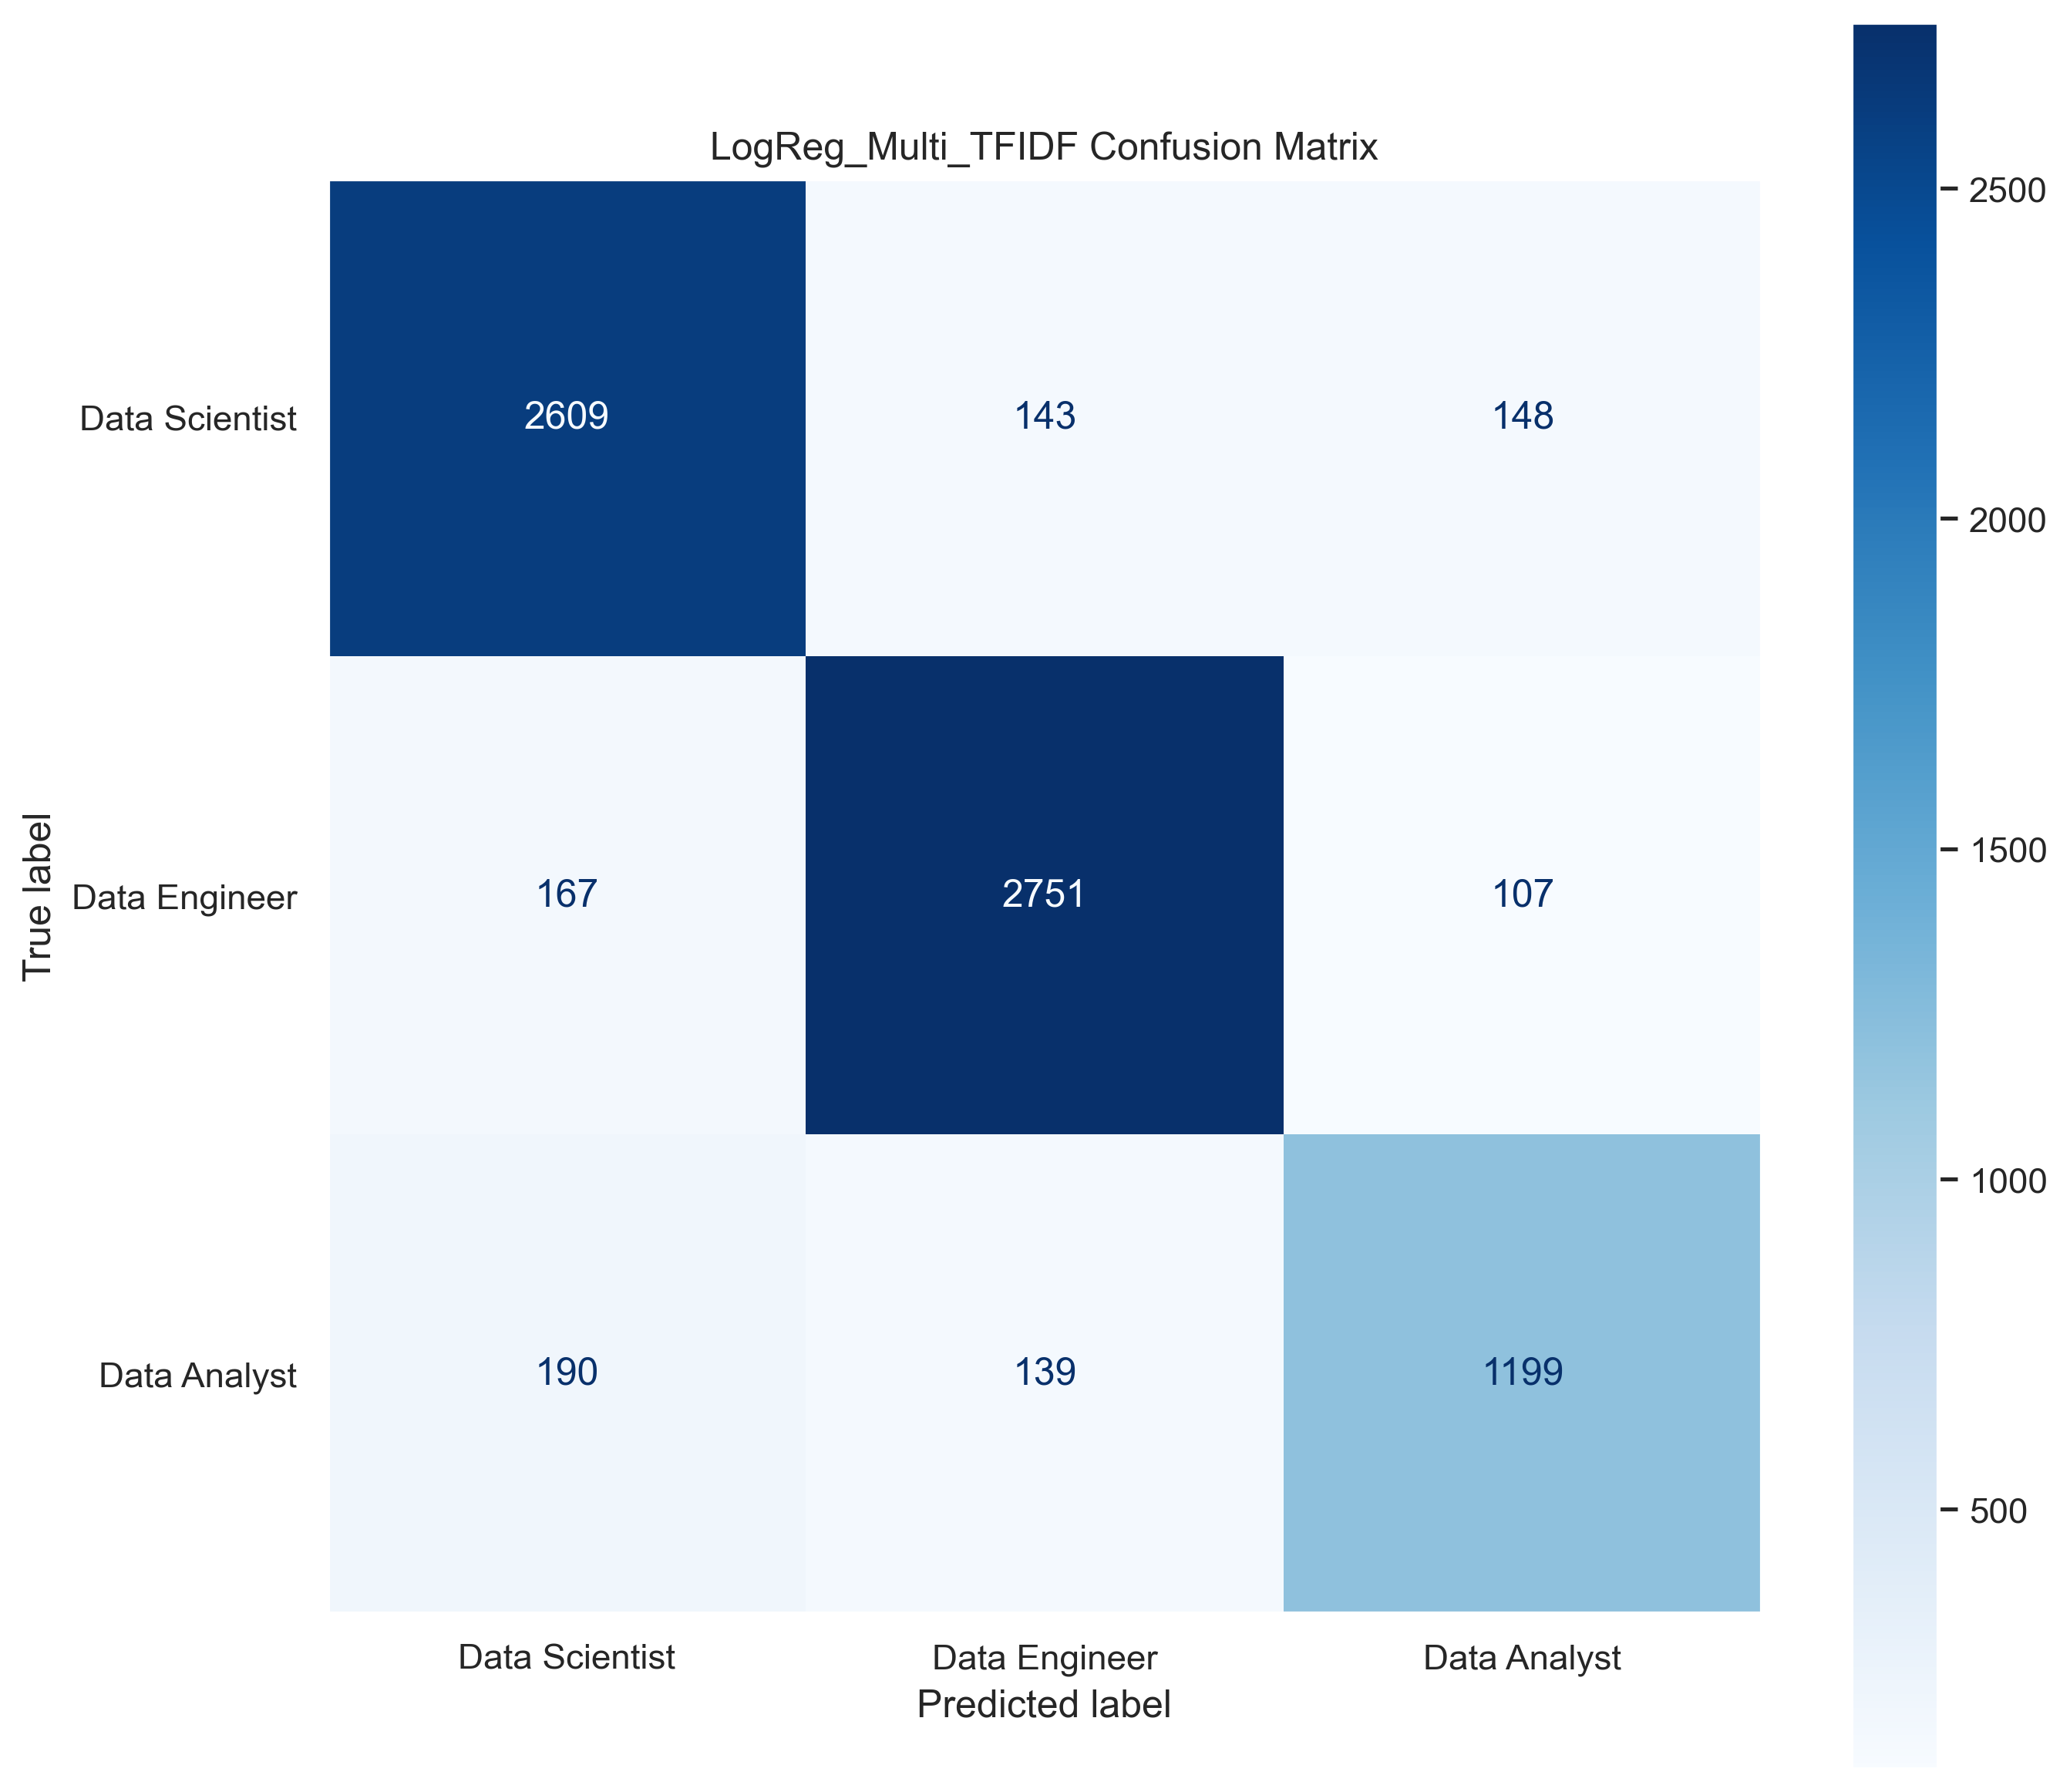

In [100]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

plot_confusion_matrix(logreg_multi_TFIDF, X_test, y_test,
                             display_labels=['Data Scientist', 'Data Engineer', 'Data Analyst'],
                             cmap=plt.cm.Blues, ax=ax)
ax.set_title('LogReg_Multi_TFIDF Confusion Matrix')

plt.grid(None)
plt.show()

In [101]:
# get importance
importance = logreg_multi_TFIDF.coef_[0]

# create empty dataframe
feature_list = []

# summarize feature importance
for i,v in enumerate(importance):
    if v > 0.5:
        feature_list.append(dict({'number': i, 'feature': tfidf_vectorizer.get_feature_names()[i], 'weight': v})) 

    if v < -0.5:
        feature_list.append(dict({'number': i, 'feature': tfidf_vectorizer.get_feature_names()[i], 'weight': v}))        
        
df_important_features = pd.DataFrame(feature_list, columns=['number', 'feature', 'weight'])
print('Top Words (Features) for Predicting Data Scientist job: \n\n', df_important_features.sort_values(by='weight', ascending=False).iloc[:10])
print('\nTop Words (Features) for Predicting Data Engineering job: \n\n', df_important_features.sort_values(by='weight', ascending=True).iloc[:10])



Top Words (Features) for Predicting Data Scientist job: 

      number      feature    weight
907   48453      science  7.777486
584   29640     learning  4.649844
656   33423        model  4.069614
979   52744    statistic  3.172504
741   39188          phd  3.087836
384   19632   experiment  3.069617
816   43674       python  3.014489
603   30837      machine  2.977213
34     1472    algorithm  2.881187
980   52747  statistical  2.796520

Top Words (Features) for Predicting Data Engineering job: 

      number   feature    weight
364   18681       etl -3.263001
251   12488      data -2.651070
199   10283  computer -2.625002
748   39382  pipeline -2.580755
375   18938     excel -2.412889
972   52048       sql -2.392477
845   45100  redshift -2.355992
862   45795    report -2.233023
89     5039  bachelor -1.817858
463   22865    google -1.766926


### 4.3 Decision Tree w/ TF-IDF (Model 3)

In [102]:
# train a Decision Tree Classifier 
dtree_TFIDF = DecisionTreeClassifier(max_depth = 3)
dtree_TFIDF.fit(X_train, y_train) 
y_pred = dtree_TFIDF.predict(X_test) 

In [103]:
# compute y-prediction and accuracy, recall, precision, and f1 scores
y_pred = dtree_TFIDF.predict(X_test) 
mod3_acc = accuracy_score(y_test, y_pred)
mod3_recall = recall_score(y_test, y_pred, average = 'macro')
mod3_precision = precision_score(y_test, y_pred, average = 'macro')
mod3_f1 = f1_score(y_test, y_pred, average = 'macro')

# print accuracy, recall, precision, f1 score, detailed report
print('---------------------------------------')
print('Model 3 accuracy: ', round(mod3_acc,3))
print('Model 3 recall: ', round(mod3_recall,3))
print('Model 3 precision: ', round(mod3_precision,3))
print('Model 3 f1 : ', round(mod3_f1,3))
print('Model 3 classification report: \n',classification_report(y_test, y_pred))


---------------------------------------
Model 3 accuracy:  0.648
Model 3 recall:  0.599
Model 3 precision:  0.697
Model 3 f1 :  0.611
Model 3 classification report: 
               precision    recall  f1-score   support

           0       0.79      0.58      0.67      2900
           1       0.57      0.86      0.69      3025
           2       0.74      0.36      0.48      1528

    accuracy                           0.65      7453
   macro avg       0.70      0.60      0.61      7453
weighted avg       0.69      0.65      0.64      7453



In [104]:
# append model results to dataframe
model_results = model_results.append({'model': 'DecisionTree_TFIDF',
                      'accuracy':round(mod3_acc,3),
                      'recall': round(mod3_recall,3),
                      'precision': round(mod3_precision,3),
                      'f1': round(mod3_f1,3)}, ignore_index=True)

model_results

,model,accuracy,precision,recall,f1
0,LogReg_OVR_TFIDF,0.872,0.863,0.853,0.857
1,LogReg_Multi_TFIDF,0.880,0.870,0.865,0.867
2,DecisionTree_TFIDF,0.648,0.697,0.599,0.611


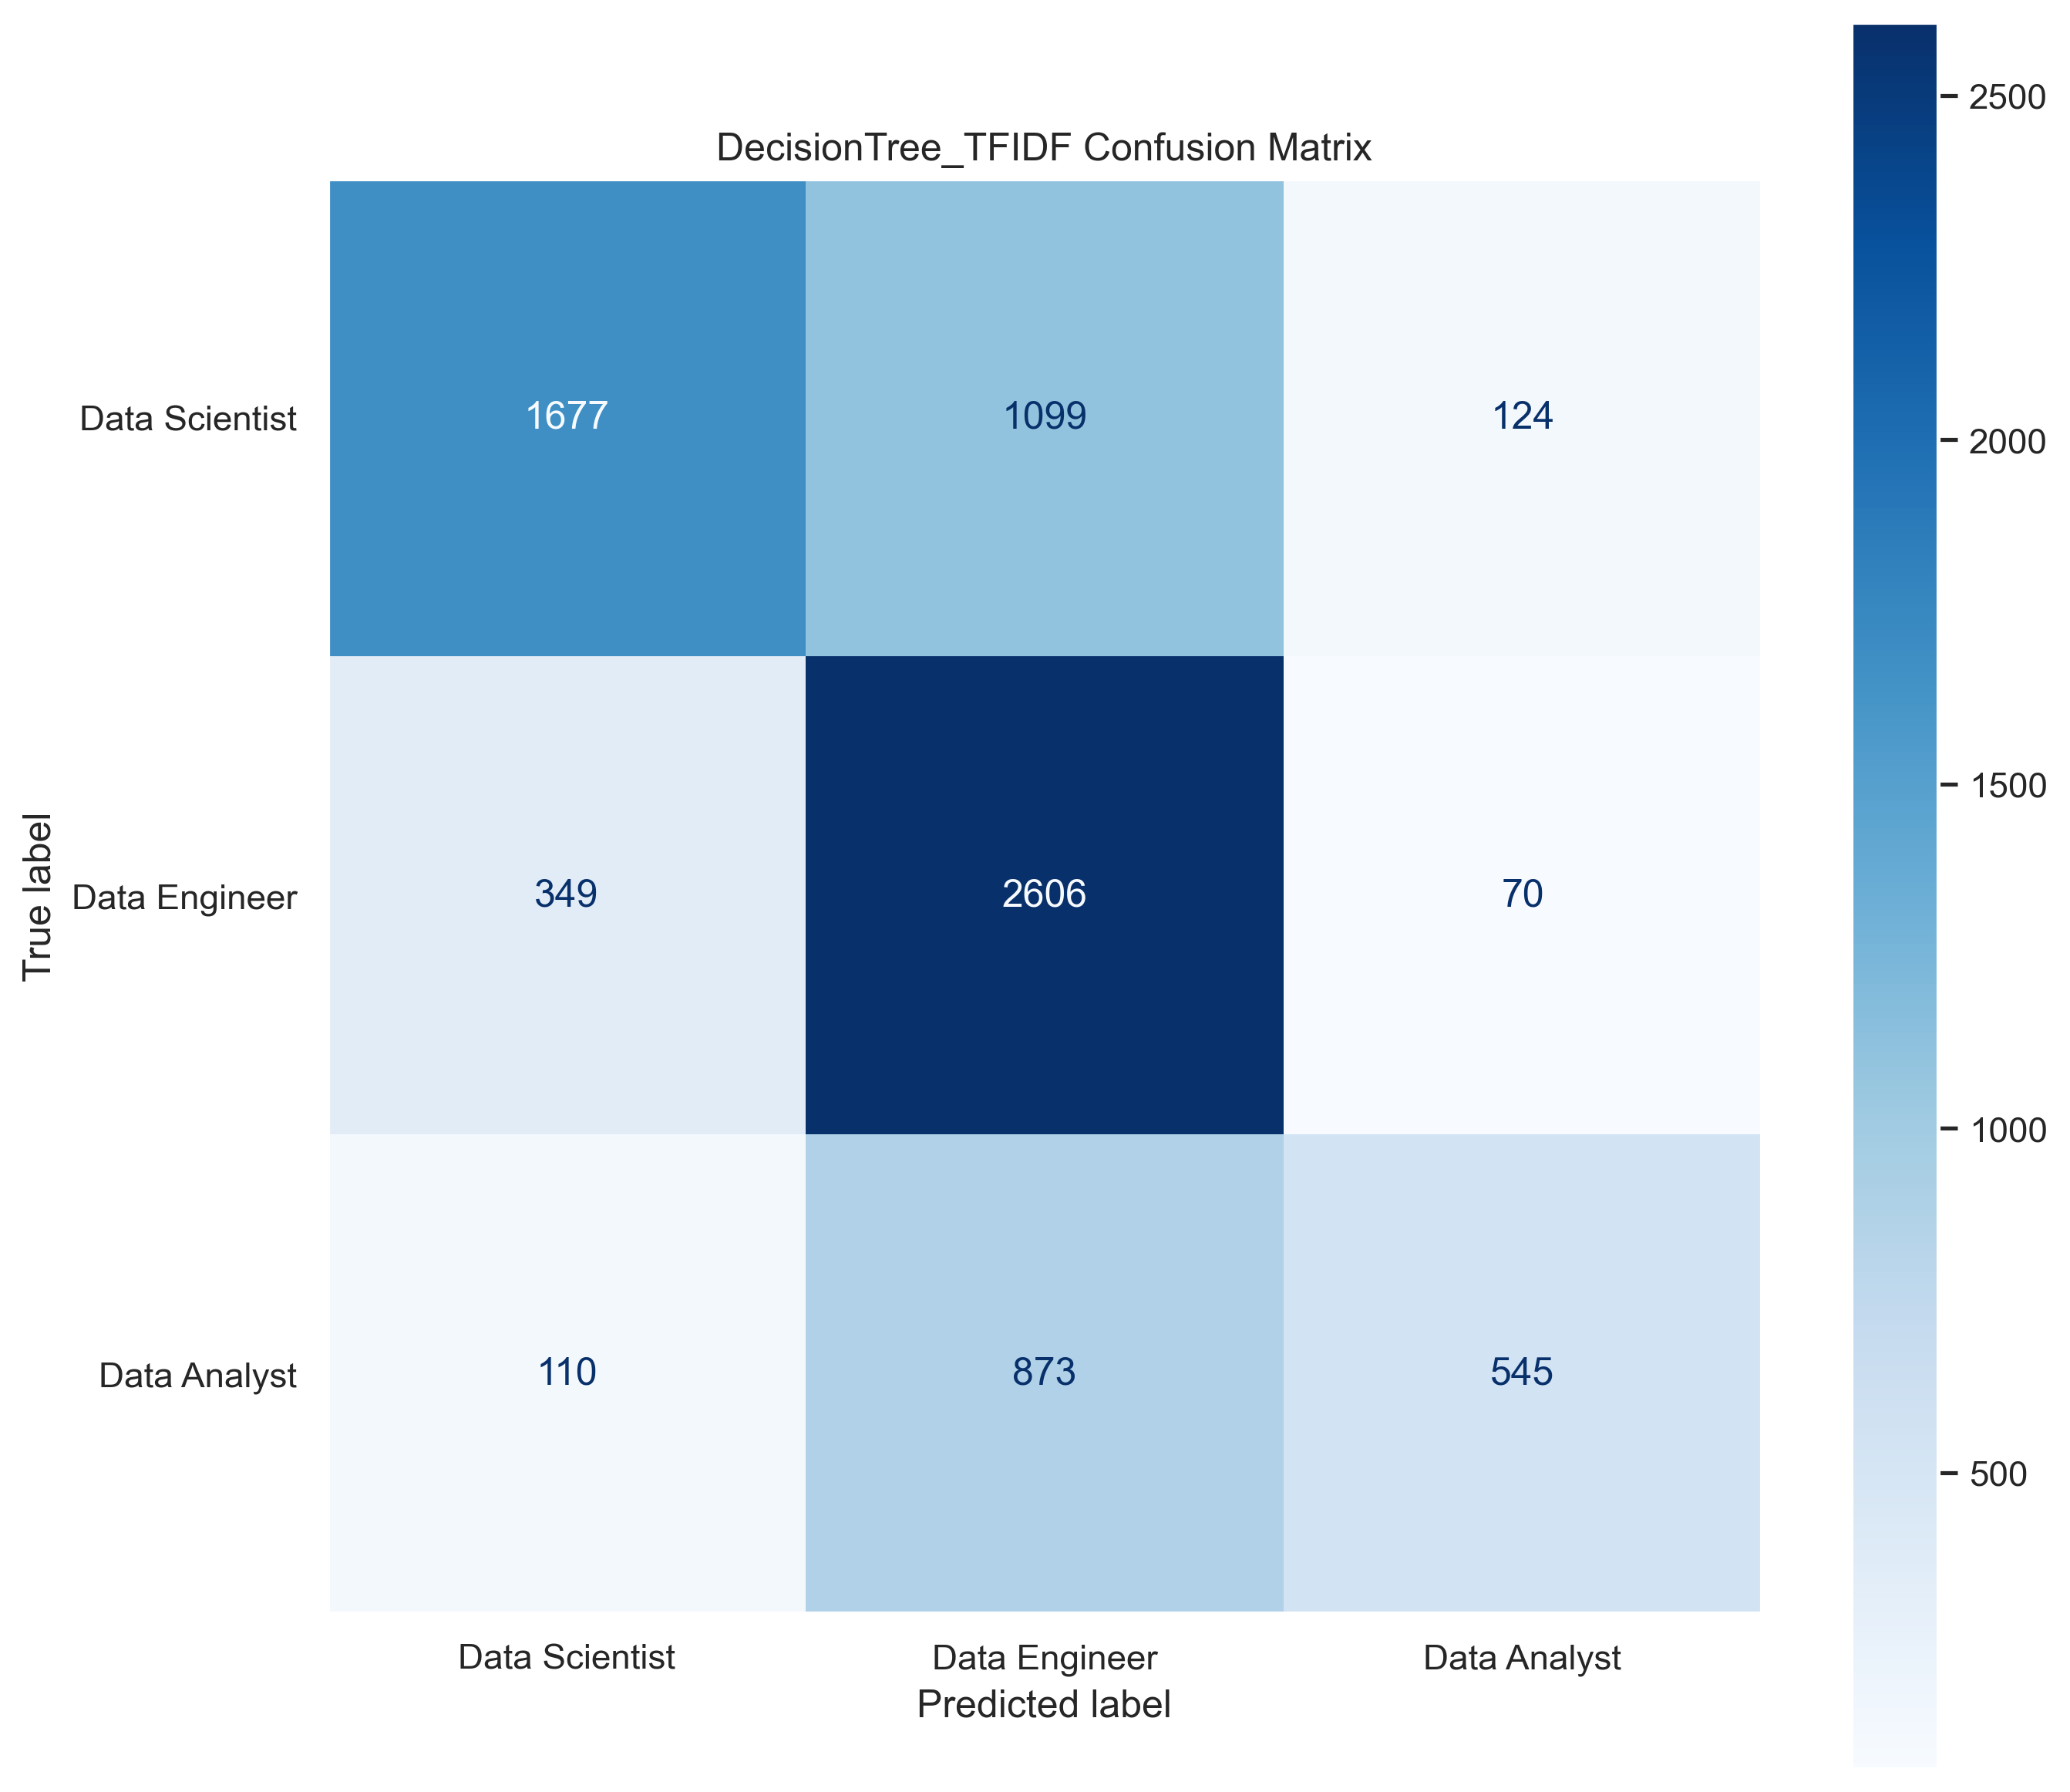

In [105]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

plot_confusion_matrix(dtree_TFIDF, X_test, y_test,
                             display_labels=['Data Scientist', 'Data Engineer', 'Data Analyst'],
                             cmap=plt.cm.Blues, ax=ax)
ax.set_title('DecisionTree_TFIDF Confusion Matrix')

plt.grid(None)
plt.show()

### 4.4 K-Nearest Neighbors w/ TF-IDF (Model 4)

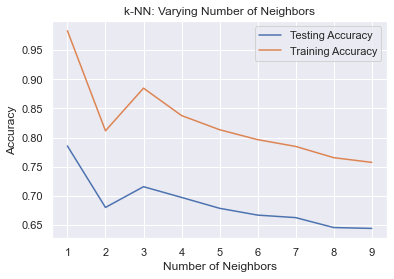

In [106]:
# setup plot to determine optimal number of neighbors
neighbors = np.arange(1, 10)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors= k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [107]:
# train an KNN Classifier 
KNN_TFIDF = KNeighborsClassifier(n_neighbors = 3)
KNN_TFIDF.fit(X_train, y_train) 

KNeighborsClassifier(n_neighbors=3)

In [108]:
# compute y-prediction and accuracy, recall, precision, and f1 scores
y_pred = KNN_TFIDF.predict(X_test)
mod4_acc = accuracy_score(y_test, y_pred)
mod4_recall = recall_score(y_test, y_pred, average = 'macro')
mod4_precision = precision_score(y_test, y_pred, average = 'macro')
mod4_f1 = f1_score(y_test, y_pred, average = 'macro')

# print accuracy, recall, precision, f1 score, detailed report
print('---------------------------------------')
print('Model 4 accuracy: ', round(mod4_acc,3))
print('Model 4 recall: ', round(mod4_recall,3))
print('Model 4 precision: ', round(mod4_precision,3))
print('Model 4 f1 : ', round(mod4_f1,3))
print('Model 4 classification report: \n',classification_report(y_test, y_pred))


---------------------------------------
Model 4 accuracy:  0.716
Model 4 recall:  0.68
Model 4 precision:  0.802
Model 4 f1 :  0.697
Model 4 classification report: 
               precision    recall  f1-score   support

           0       0.60      0.95      0.74      2900
           1       0.91      0.61      0.73      3025
           2       0.90      0.48      0.63      1528

    accuracy                           0.72      7453
   macro avg       0.80      0.68      0.70      7453
weighted avg       0.79      0.72      0.71      7453



In [109]:
# append model results to dataframe
model_results = model_results.append({'model': 'KNN_TFIDF',
                      'accuracy':round(mod4_acc,3),
                      'recall': round(mod4_recall,3),
                      'precision': round(mod4_precision,3),
                      'f1': round(mod4_f1,3)}, ignore_index=True)

model_results

,model,accuracy,precision,recall,f1
0,LogReg_OVR_TFIDF,0.872,0.863,0.853,0.857
1,LogReg_Multi_TFIDF,0.880,0.870,0.865,0.867
2,DecisionTree_TFIDF,0.648,0.697,0.599,0.611
3,KNN_TFIDF,0.716,0.802,0.680,0.697


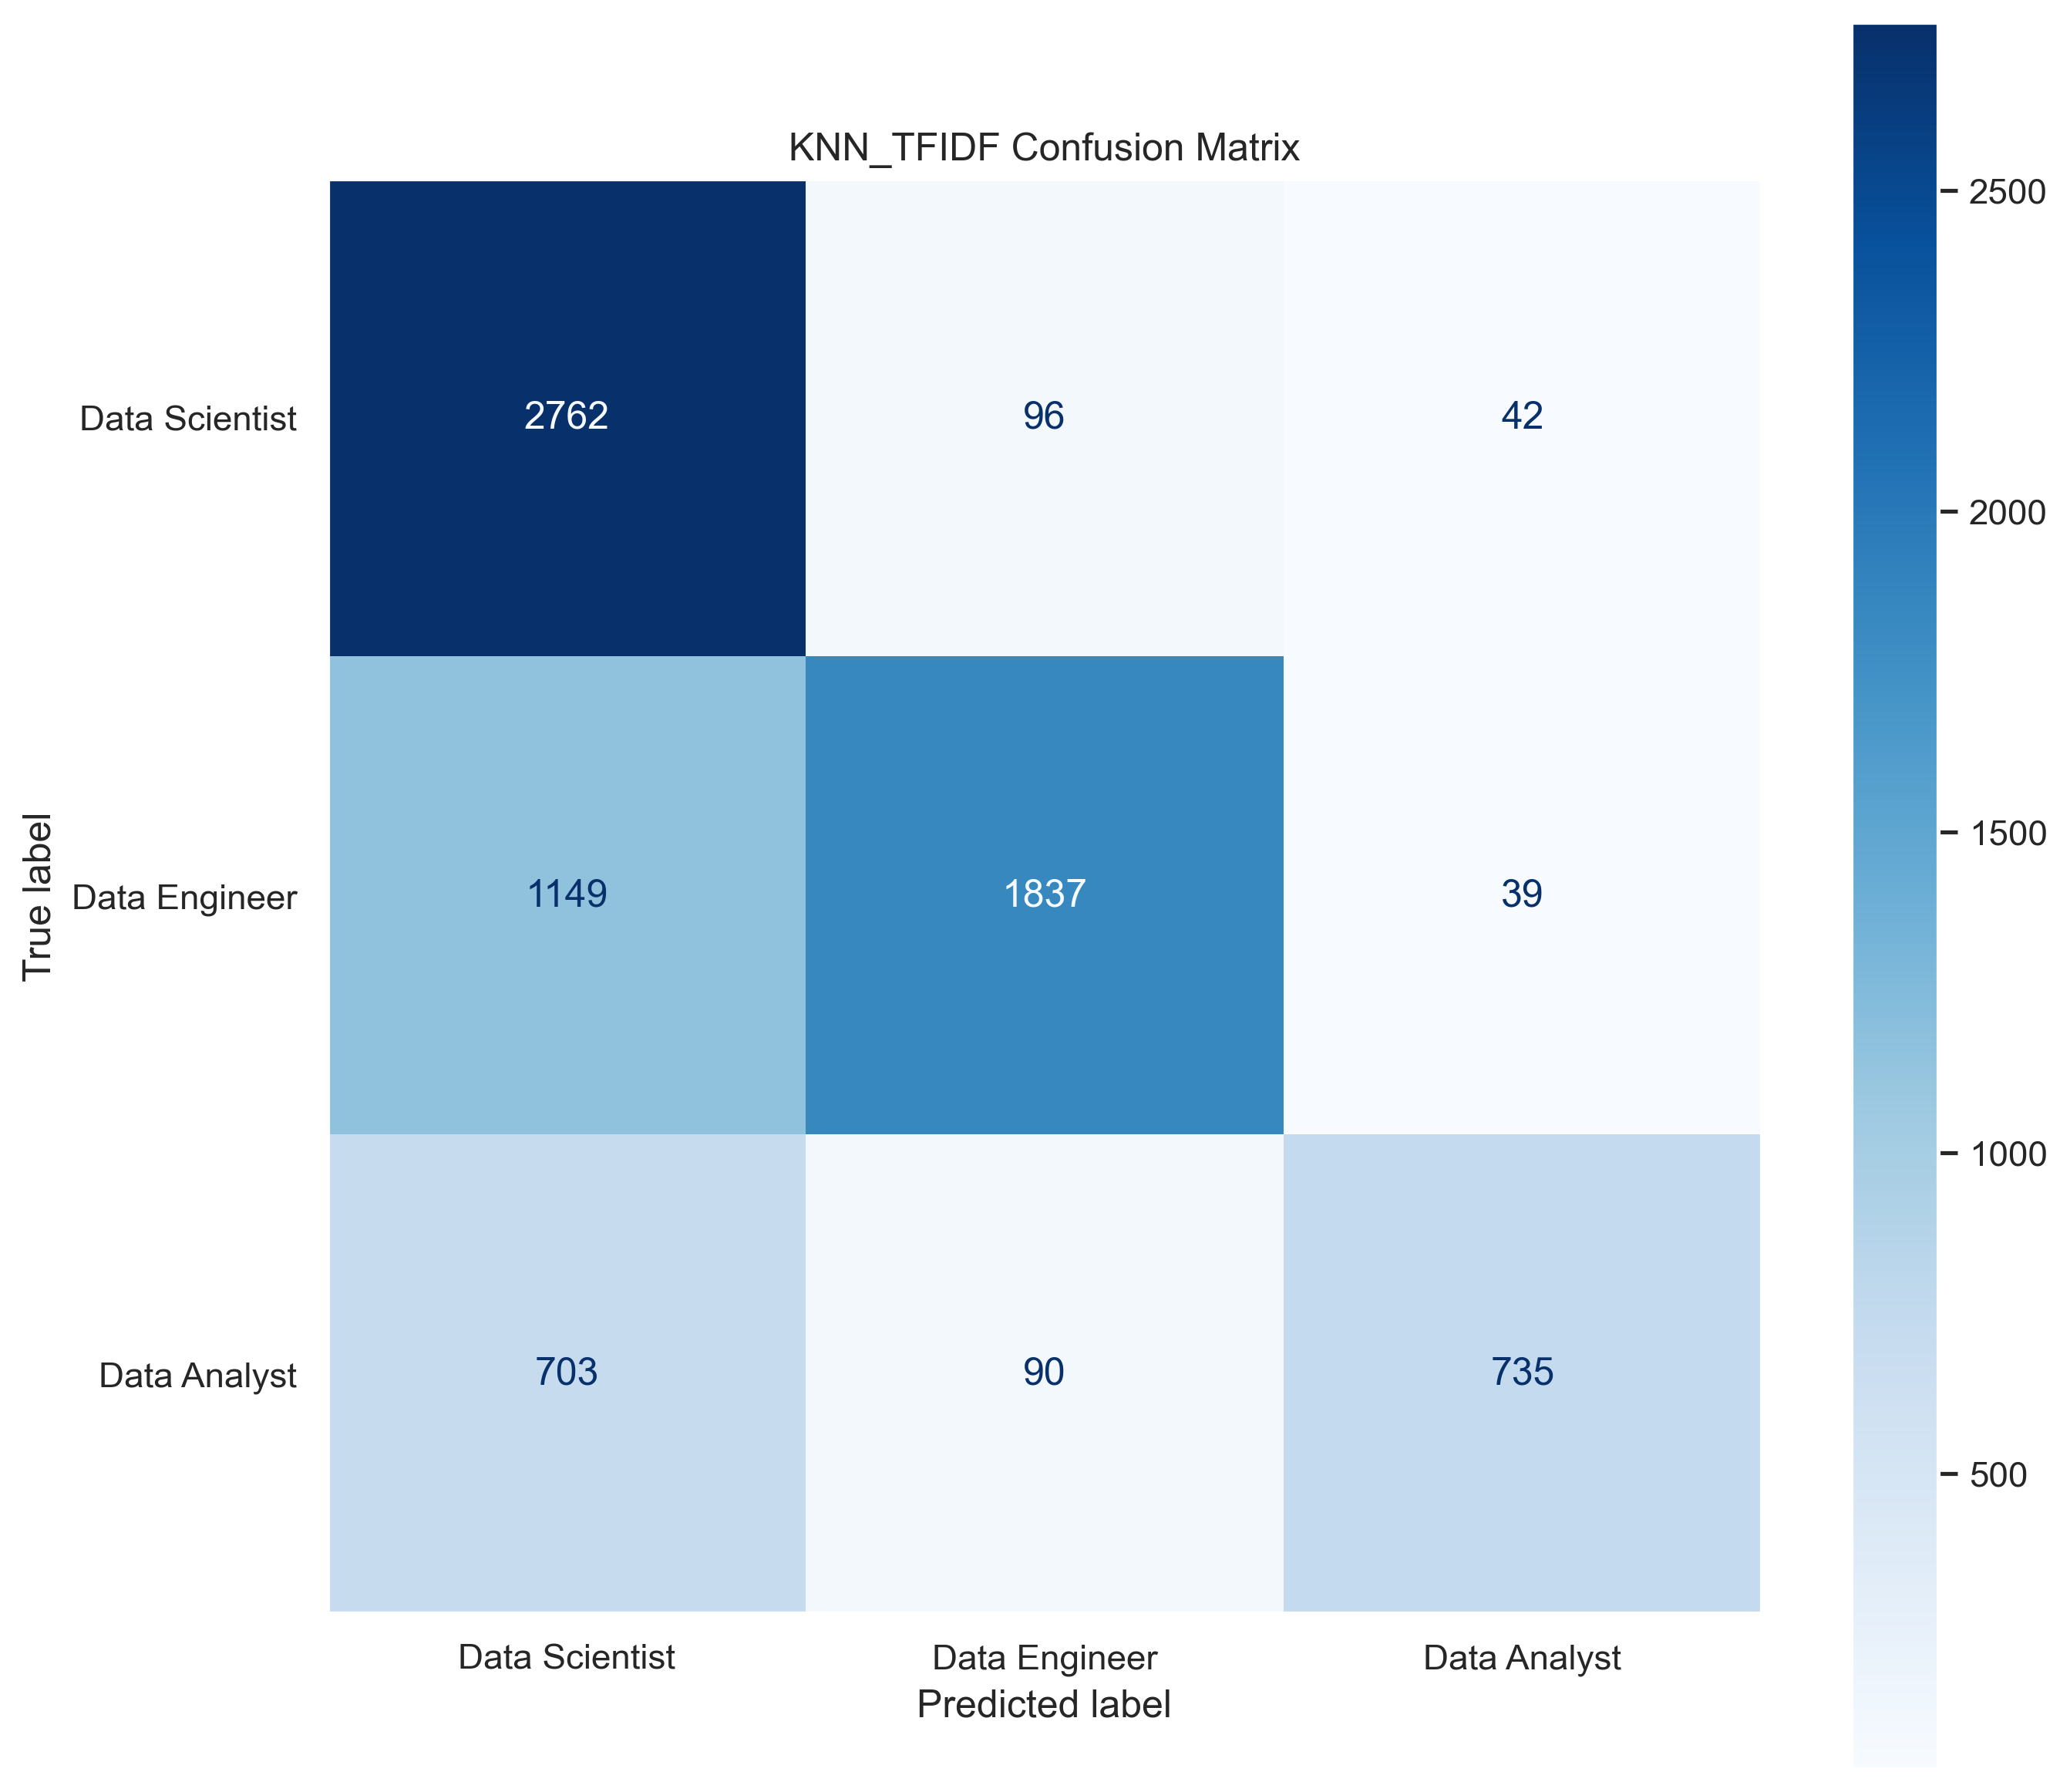

In [110]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

plot_confusion_matrix(KNN_TFIDF, X_test, y_test,
                             display_labels=['Data Scientist', 'Data Engineer', 'Data Analyst'],
                             cmap=plt.cm.Blues, ax=ax)
ax.set_title('KNN_TFIDF Confusion Matrix')

plt.grid(None)
plt.show()

### 4.5 Naive Bayes w/ TF-IDF (Model 5)

In [111]:
# convert to non-sparse matrix for GaussianNB
X_train = X_train.todense()
X_test = X_test.todense()

# train a GaussianNB Classifier 
GaussianNB_TFIDF = GaussianNB()
GaussianNB_TFIDF.fit(X_train, y_train) 

GaussianNB()

In [112]:
# compute y-prediction and accuracy, recall, precision, and f1 scores
y_pred = GaussianNB_TFIDF.predict(X_test)
mod5_acc = accuracy_score(y_test, y_pred)
mod5_recall = recall_score(y_test, y_pred, average = 'macro')
mod5_precision = precision_score(y_test, y_pred, average = 'macro')
mod5_f1 = f1_score(y_test, y_pred, average = 'macro')

# print accuracy, recall, precision, f1 score, detailed report
print('---------------------------------------')
print('Model 5 accuracy: ', round(mod5_acc,3))
print('Model 5 recall: ', round(mod5_recall,3))
print('Model 5 precision: ', round(mod5_precision,3))
print('Model 5 f1 : ', round(mod5_f1,3))
print('Model 5 classification report: \n',classification_report(y_test, y_pred))


---------------------------------------
Model 5 accuracy:  0.613
Model 5 recall:  0.643
Model 5 precision:  0.66
Model 5 f1 :  0.611
Model 5 classification report: 
               precision    recall  f1-score   support

           0       0.75      0.59      0.66      2900
           1       0.86      0.54      0.66      3025
           2       0.37      0.79      0.51      1528

    accuracy                           0.61      7453
   macro avg       0.66      0.64      0.61      7453
weighted avg       0.72      0.61      0.63      7453



In [113]:
# append model results to dataframe
model_results = model_results.append({'model': 'GaussianNB_TFIDF',
                      'accuracy':round(mod5_acc,3),
                      'recall': round(mod5_recall,3),
                      'precision': round(mod5_precision,3),
                      'f1': round(mod5_f1,3)}, ignore_index=True)

model_results

,model,accuracy,precision,recall,f1
0,LogReg_OVR_TFIDF,0.872,0.863,0.853,0.857
1,LogReg_Multi_TFIDF,0.880,0.870,0.865,0.867
2,DecisionTree_TFIDF,0.648,0.697,0.599,0.611
3,KNN_TFIDF,0.716,0.802,0.680,0.697
4,GaussianNB_TFIDF,0.613,0.660,0.643,0.611


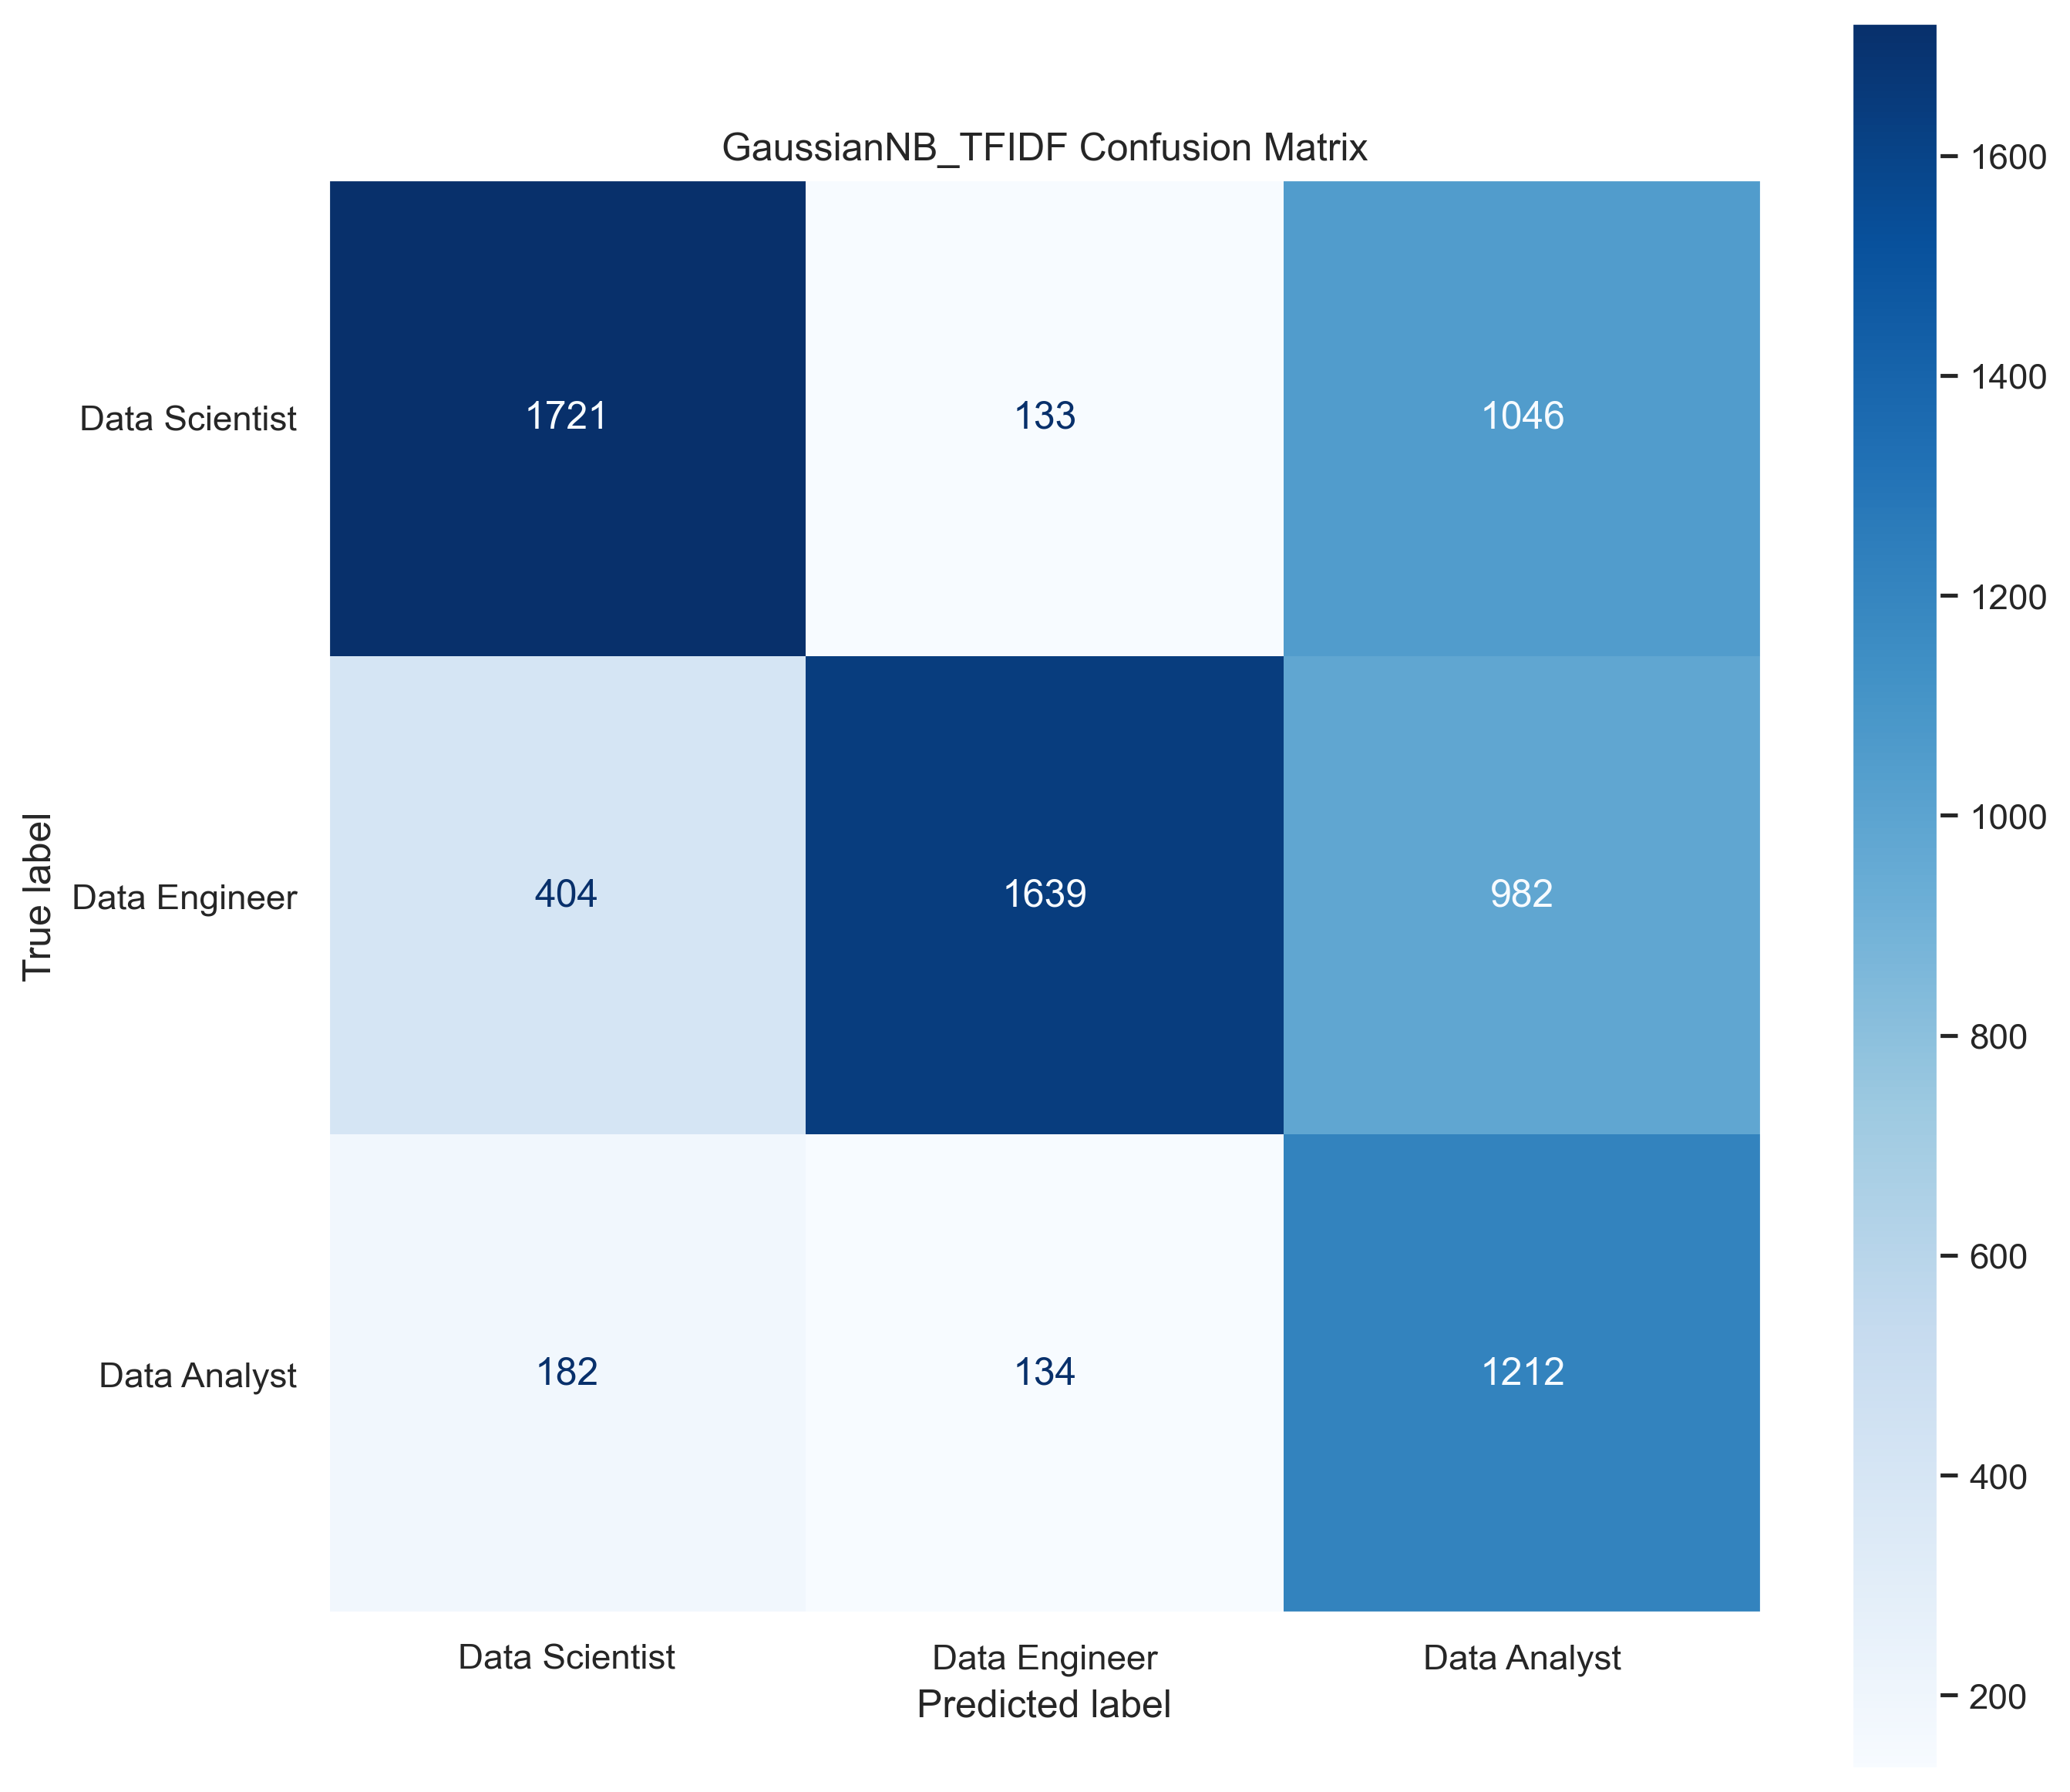

In [114]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

plot_confusion_matrix(GaussianNB_TFIDF, X_test, y_test,
                             display_labels=['Data Scientist', 'Data Engineer', 'Data Analyst'],
                             cmap=plt.cm.Blues, ax=ax)
ax.set_title('GaussianNB_TFIDF Confusion Matrix')

plt.grid(None)
plt.show()

### 4.6 Choose Best Model and Optimize Hyperparameters

In [115]:
# split train/test data 80/20
X_train, X_test, y_train, y_test = train_test_split(df_feature_TFIDF, 
                                                    df_target, 
                                                    train_size=0.8, 
                                                    random_state=20)

# scale data
sc = StandardScaler(with_mean=False)
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [116]:
# choose parameters
tuned_parameters = [{'estimator__C': [100, 10, 1, 0.1, 0.01]}]

# find optimal C by grid search and fit 
logreg_OVR = OneVsRestClassifier(LogisticRegression(max_iter=1000))
grid = GridSearchCV(logreg_OVR, tuned_parameters, scoring = 'f1_weighted', verbose=2, cv=3)
grid.fit(X_train, y_train)

# print best score/parameter
print(grid.best_score_)
print(grid.best_params_)

# compute y-prediction
y_pred = grid.predict(X_test)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] estimator__C=100 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV] ................................. estimator__C=100, total=  47.4s
[CV] estimator__C=100 ................................................


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[CV] ................................. estimator__C=100, total=  49.1s
[CV] estimator__C=100 ................................................


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[CV] ................................. estimator__C=100, total=  47.0s
[CV] estimator__C=10 .................................................


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[CV] .................................. estimator__C=10, total=  46.9s
[CV] estimator__C=10 .................................................


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[CV] .................................. estimator__C=10, total=  47.3s
[CV] estimator__C=10 .................................................


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[CV] .................................. estimator__C=10, total=  47.5s
[CV] estimator__C=1 ..................................................
[CV] ................................... estimator__C=1, total=  38.8s
[CV] estimator__C=1 ..................................................
[CV] ................................... estimator__C=1, total=  38.1s
[CV] estimator__C=1 ..................................................
[CV] ................................... estimator__C=1, total=  33.7s
[CV] estimator__C=0.1 ................................................
[CV] ................................. estimator__C=0.1, total=  15.8s
[CV] estimator__C=0.1 ................................................
[CV] ................................. estimator__C=0.1, total=  14.1s
[CV] estimator__C=0.1 ................................................
[CV] ................................. estimator__C=0.1, total=  13.6s
[CV] estimator__C=0.01 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  7.7min finished


0.8764449715162215
{'estimator__C': 0.01}


In [117]:
mod6_acc = accuracy_score(y_test, y_pred)
mod6_recall = recall_score(y_test, y_pred, average = 'macro')
mod6_precision = precision_score(y_test, y_pred, average = 'macro')
mod6_f1 = f1_score(y_test, y_pred, average = 'macro')

# print accuracy, recall, precision, f1 score, detailed report
print('---------------------------------------')
print('Model 6 accuracy: ', round(mod6_acc,3))
print('Model 6 recall: ', round(mod6_recall,3))
print('Model 6 precision: ', round(mod6_precision,3))
print('Model 6 f1 : ', round(mod6_f1,3))
print('Model 6 classification report: \n',classification_report(y_test, y_pred))


---------------------------------------
Model 6 accuracy:  0.891
Model 6 recall:  0.873
Model 6 precision:  0.882
Model 6 f1 :  0.877
Model 6 classification report: 
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      2900
           1       0.91      0.93      0.92      3025
           2       0.84      0.78      0.81      1528

    accuracy                           0.89      7453
   macro avg       0.88      0.87      0.88      7453
weighted avg       0.89      0.89      0.89      7453



In [118]:
# append model results to dataframe
model_results = model_results.append({'model': 'LogReg_OVR_TFIDF_optimized',
                      'accuracy':round(mod6_acc,3),
                      'recall': round(mod6_recall,3),
                      'precision': round(mod6_precision,3),
                      'f1': round(mod6_f1,3)}, ignore_index=True)

model_results = model_results.sort_values(by='accuracy')
model_results

,model,accuracy,precision,recall,f1
4,GaussianNB_TFIDF,0.613,0.660,0.643,0.611
2,DecisionTree_TFIDF,0.648,0.697,0.599,0.611
3,KNN_TFIDF,0.716,0.802,0.680,0.697
0,LogReg_OVR_TFIDF,0.872,0.863,0.853,0.857
1,LogReg_Multi_TFIDF,0.880,0.870,0.865,0.867
5,LogReg_OVR_TFIDF_optimized,0.891,0.882,0.873,0.877


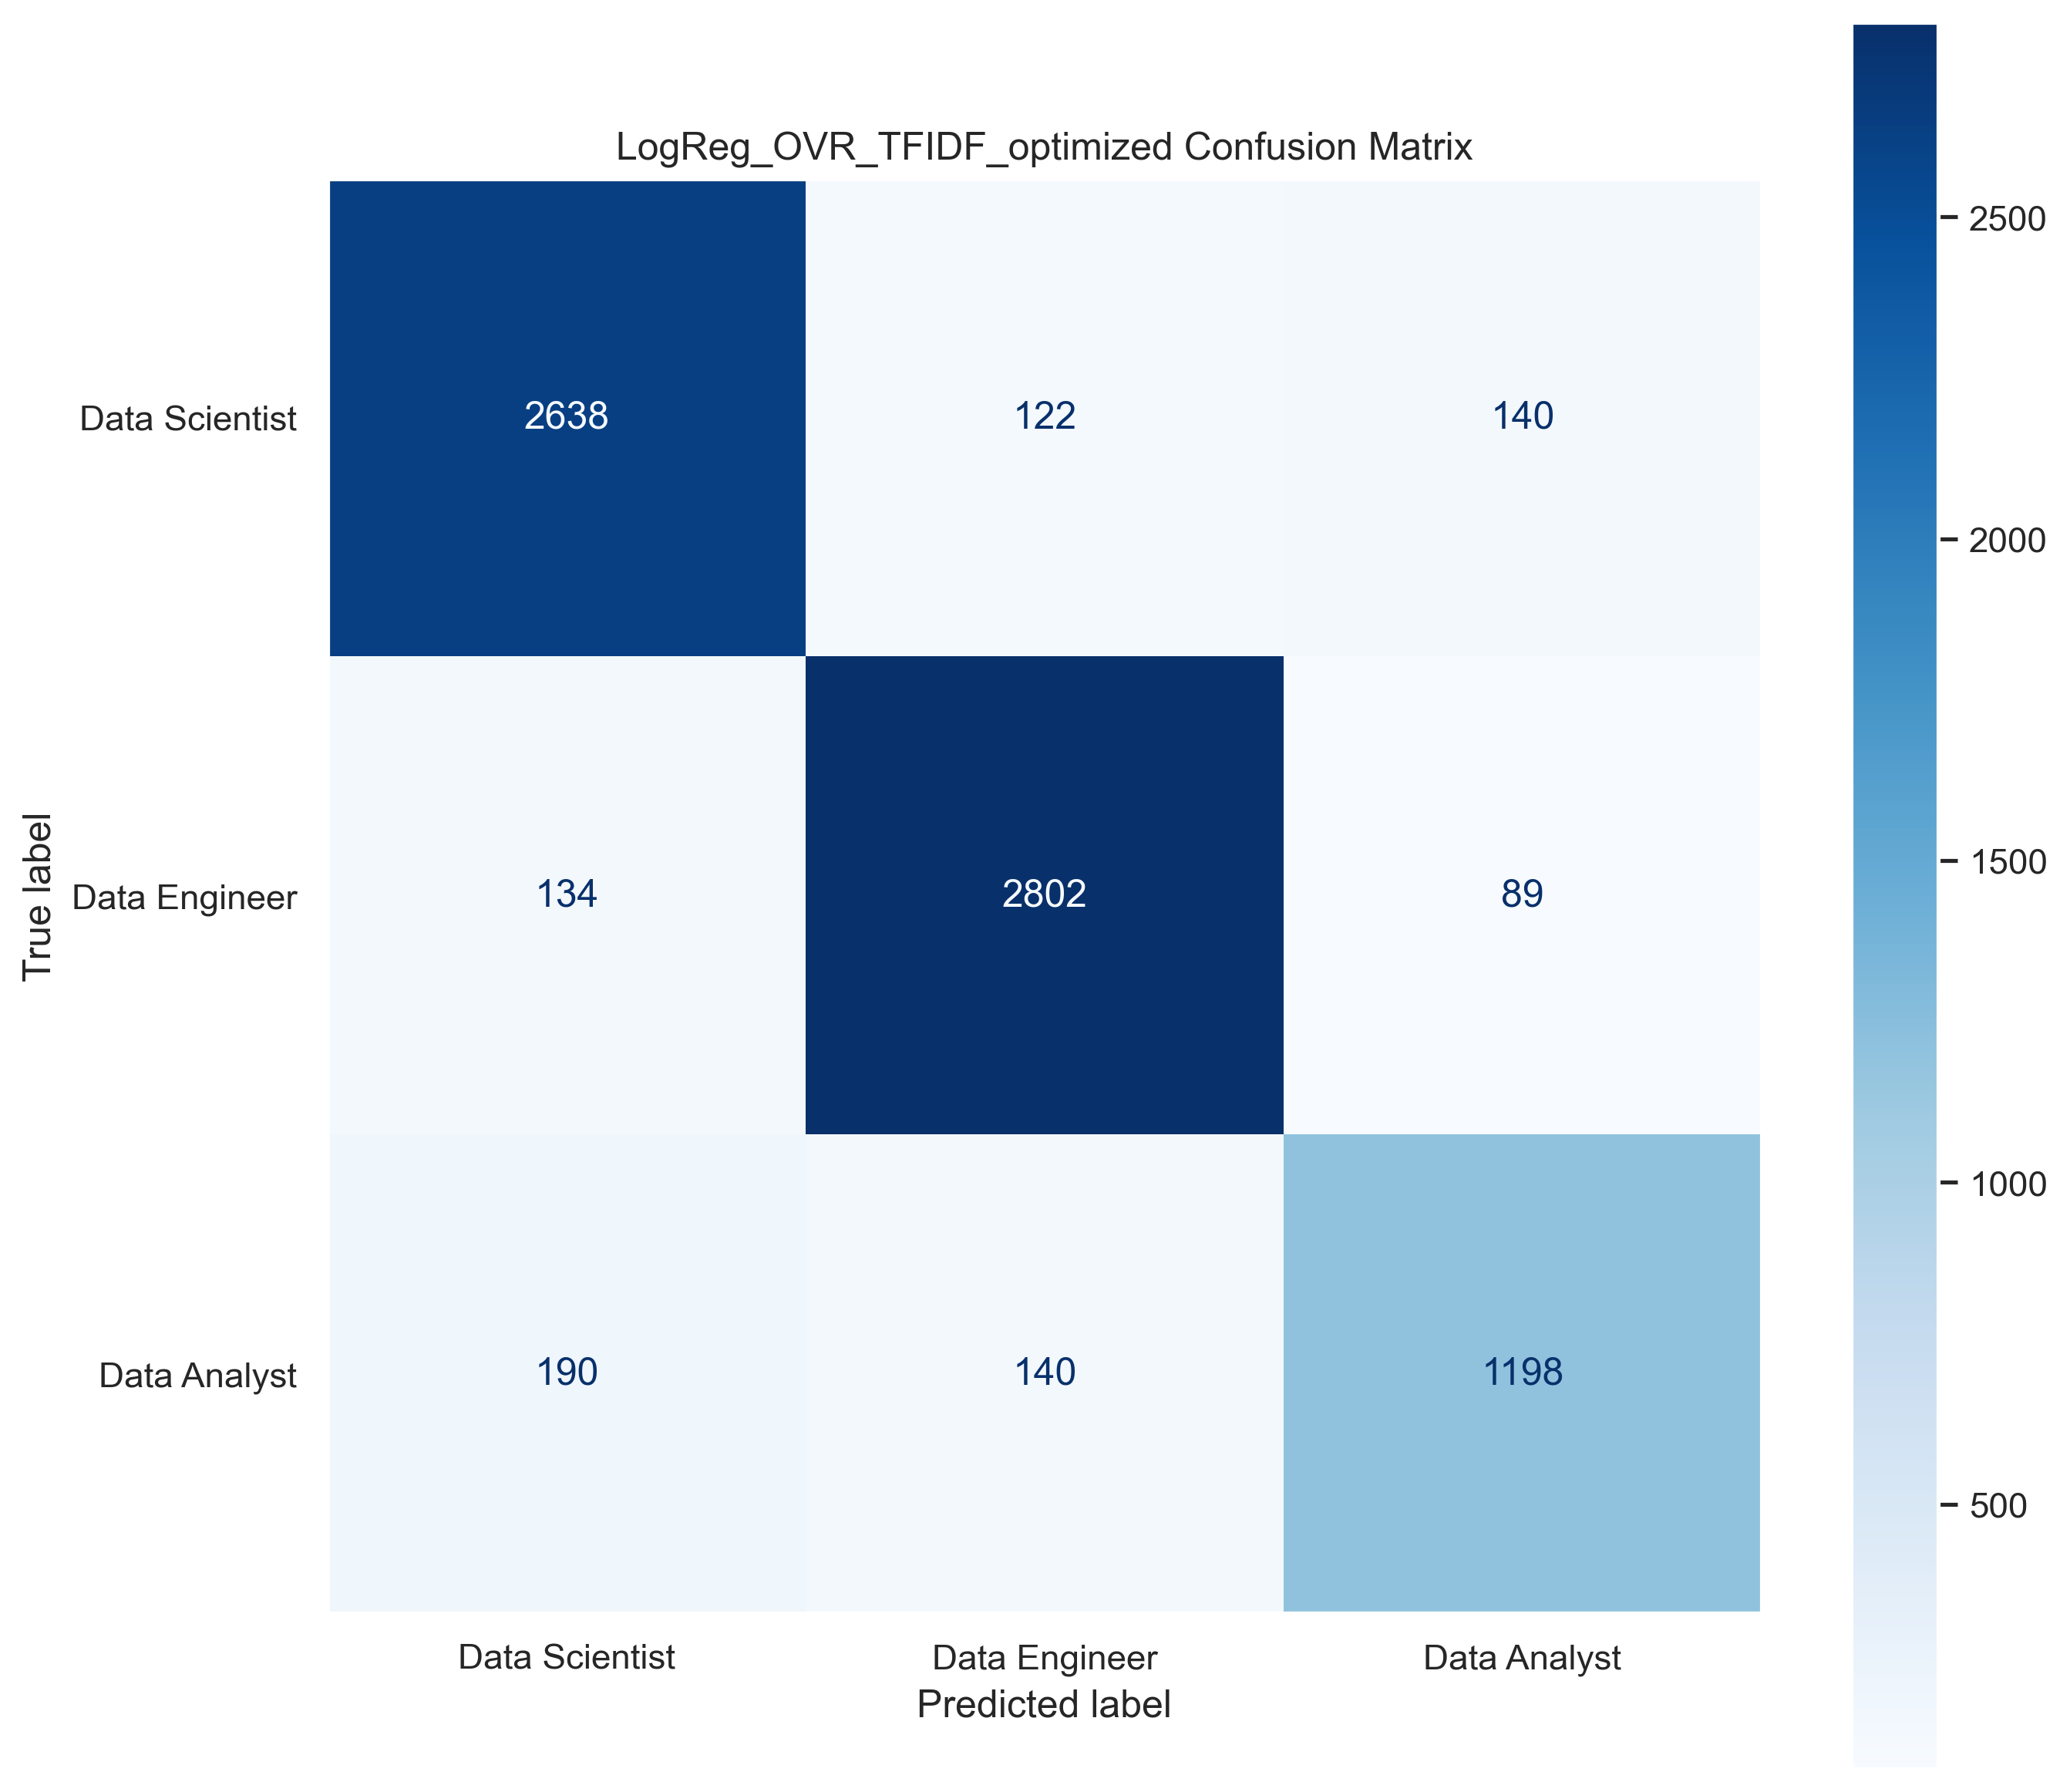

In [120]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

plot_confusion_matrix(grid, X_test, y_test,
                             display_labels=['Data Scientist', 'Data Engineer', 'Data Analyst'],
                             cmap=plt.cm.Blues, ax=ax)
ax.set_title('LogReg_OVR_TFIDF_optimized Confusion Matrix')

plt.grid(None)
plt.show()

## 5. Conclusion

This project reviewed data-related job postings and tried to answer the following questions. The answers and results are shown below:

### **What tools/skills are most in demand for a *Data Analyst?***

For a Data Analyst, the top desired tools are: *sql, excel, tableau, python, and r*. The top desired skills (after parsing through some useless bigrams) are: *data analysis, communication skill, and data visualization*. See section 3.1 for the full list and plot of tools/skills frequency. 

### **What tools/skills are most in demand for a *Data Engineer?***

For a Data Engineer, the top desired tools are: *sql, python, aws, spark, and azure*. The top desired skills (after parsing through some useless bigrams) are: *data pipeline, big data, and data warehouse*. See section 3.1 for the full list and plot of tools/skills frequency. 

### **What tools/skills are most in demand for a *Data Scientist?***

For a Data Scientist, the top desired tools are: *python, r, sql, spark, and tableau*. The top desired skills (after parsing through some useless bigrams) are: *machine learning, data analysis, and communication skill*. See section 3.1 for the full list and plot of tools/skills frequency. 

### **Which companies post the mose job openings?**

For Data Analyst postings, the top companies are: *ClearedJobs.Net, GEICO, CyberCoders, Booz Allen Hamilton, and Apex Systems*. See section 3.3 for the full list and plot of job company frequency. 

For Data Engineer postings, the top companies are: *Amazon, Optello, Facebook, Apple, and CyberCoders*. See section 3.3 for the full list and plot of job company frequency. 

For Data Scientist postings, the top companies are: *Amazon, Facebook, Booz Allen Hamilton, Apple, and Optello*. See section 3.3 for the full list and plot of job company frequency. 

### **Can a classifier be built which predicts job role/title (Data Analyst, Data Scientist, or Data Engineer) based on job description?**

Five different initial models were chosen for the multi-class (three class) classification problem. These models included the following: Logisitic Regression (One vs. All), Logistic Regression (Multinomial), K-Nearest Neighbor, Decision Tree, and Naive Bayes. Based on an initial fitting of the model types to the classification problem and collecting model metrics, the Logistic Regression model performed the best. This model type was then further optimized via a hyperpareter grid search. The resulting best model, LogReg_OVR_TFIDF_optimized, is shown below with model performace metrics

| Model | Accuracy | Precision | Recall | f1
| :- | :-: | :-: | :-: | :-: |
| GaussianNB_TFIDF | 0.613 | 0.660 | 0.643 | 0.611 
| DecisionTree_TFIDF | 0.648 | 0.697 | 0.599 | 0.611 
| KNN_TFIDF | 0.716 | 0.802 | 0.680 | 0.697 
| LogReg_OVR_TFIDF | 0.872 | 0.863 | 0.853 | 0.857 
| LogReg_Multi_TFIDF | 0.880 | 0.870 | 0.865 | 0.867 
| LogReg_OVR_TFIDF_optimized | 0.891 | 0.882 | 0.873 | 0.877 

Next steps for improving model performance include trying additional model types, additional hyperparameter tuning (e.g. more solvers, more C estimators, more penalty terms, etc), review imbalanced classes and upsample/downsample appropriately, and try different NLP cleaning approaches (e.g. add more stopwords). 
